## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

The images for camera calibration are stored in the folder called camera_cal.

In [422]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# objp = np.zeros((6*9,3), np.float32)
# objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [423]:
images

['camera_cal/calibration1.jpg',
 'camera_cal/calibration10.jpg',
 'camera_cal/calibration11.jpg',
 'camera_cal/calibration12.jpg',
 'camera_cal/calibration13.jpg',
 'camera_cal/calibration14.jpg',
 'camera_cal/calibration15.jpg',
 'camera_cal/calibration16.jpg',
 'camera_cal/calibration17.jpg',
 'camera_cal/calibration18.jpg',
 'camera_cal/calibration19.jpg',
 'camera_cal/calibration2.jpg',
 'camera_cal/calibration20.jpg',
 'camera_cal/calibration3.jpg',
 'camera_cal/calibration4.jpg',
 'camera_cal/calibration5.jpg',
 'camera_cal/calibration6.jpg',
 'camera_cal/calibration7.jpg',
 'camera_cal/calibration8.jpg',
 'camera_cal/calibration9.jpg']

In [665]:
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

## 2. Apply a distortion correction to raw images.

In [666]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # undist = np.copy(img)  # Delete this line
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst,mtx,dist


OpenCV functions were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (calibration2.jpg).

The distortion matrix **(mtx)** is used to un-distort the calibration image. It can be seen in the undistorted image that the processing worked, as observed in the lack of a curvature in the top edge of the chessboard.

undistorting sample image:  camera_cal/calibration2.jpg


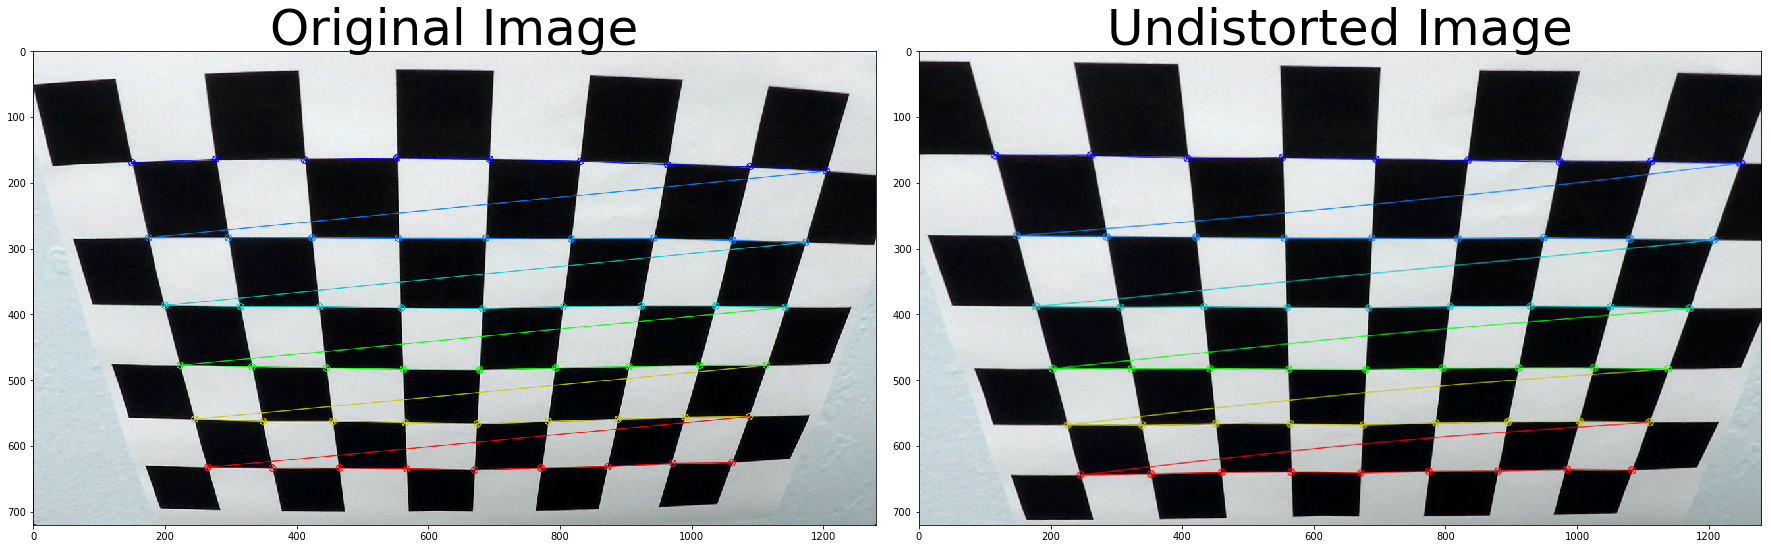

In [667]:
img = cv2.imread(images[11])
print('undistorting sample image: ',images[11])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

# If found, add object points, image points
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)
    img2 = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

undistorted,mtx,dist = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/distortion_correction_output.jpg',figsize=(1,1))

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

Described below is how I used color transforms, gradients or other methods to create a thresholded binary image. Provided is an example of a binary image result.

In [668]:
test_images = glob.glob('test_images/test*.jpg')
line_images = glob.glob('test_images/straight_lines*.jpg')
test_images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

In [711]:
def pipeline(img, s_thresh=(230, 255), sx_thresh=(50, 100)):
    img = cv2.GaussianBlur(img,(5,5),0)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    v_channel = hsv[:,:,2]    
    
    # Explore gradients in other colors spaces / color channels to see what might work better
    # Sobel x
    hls_thresh=(160,255)
    
    temp_s_out = np.zeros_like(s_channel)
    temp_s_out[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    sobelx = cv2.Sobel(temp_s_out, cv2.CV_64F, 1, 0,ksize=11) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = sx_thresh[0]
    thresh_max = sx_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(v_channel)
    s_binary[(v_channel >= s_thresh_min) & (v_channel <= s_thresh_max)] = 1
        
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary,color_binary    

**Provided below are examples of binary image result.**

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

The code for my perspective transform includes a function called warper(), which appears in lines 1 through 8 in the file example.py (examples/example.py) . The warper() function takes as inputs an image (img), as well as source (src) and destination (dst) points. I chose the hardcode the source and destination points in the following manner:



In [690]:
def warper(img, 
            src=np.float32([(580,460),
                   (702,460), 
                   (1124,720),
                   (201,720) 
                   ]) , 
           dst = np.float32([(450,0),
                  (1200-450,0),
                  (1200-450,720),
                  (450,720)
                  ])
          ):

#     src=np.float32([(580,460),
#            (702,460), 
#            (1124,720),
#            (201,720) 
#            ]) 
#     dst = np.float32([(320,0),
#            (960,0),
#            (960,720),
#            (320,720)
#            ]) 

    # Compute and apply perpective transform
    # Return transform matrix
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    
    return warped,M,Minv


def undistort(img,mtx,dist):
    undistorted=cv2.undistort(img,mtx,dist,None,mtx)
    return undistorted

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


## 5. Detect lane pixels and fit to find the lane boundary.

In [691]:
def sliding_window(image=None,mtx=mtx,dist=dist, nwindows = 10,margin = 90,minpix = 50):
    undistorted = undistort(image, mtx,dist)
    img_size=undistorted.shape
    w=img_size[1]
    h=img_size[0]
    
    warped,perspective_M,return_M =  warper(undistorted)    
#     binary_warped,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))
    binary_warped,stack_binary= pipeline(warped)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    

    # # Find the peak of the left and right halves of the histogram
    # # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img,return_M,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    

In [692]:
def get_curvature(ploty,lefty,righty,leftx,rightx,
                  xm_per_pix = 3.7/700,ym_per_pix = 30/720):
    #     lefty/righty is the actual pixel sample's y-value
    #     leftx/rightx is the actual pixel sample's x-value

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #     print(left_curverad, 'm', right_curverad, 'm')

    return left_curverad,right_curverad


In [693]:
def extract_curvature(left_line=None,right_line=None):
    l_radius_of_curvature,r_radius_of_curvature = get_curvature(ploty=left_line.ploty, \
                                                 lefty=left_line.ally, \
                                                 righty=right_line.ally,\
                                                 leftx=left_line.allx,\
                                                 rightx=right_line.allx)
    return l_radius_of_curvature,r_radius_of_curvature


def extract_roc(left_line=None,right_line=None):
    l_radius_of_curvature=get_curvature(left_line)
    return l_radius_of_curvature,r_radius_of_curvature


In [694]:
def update_lanes(image=None,mtx=mtx,dist=dist
                 , nwindows = 9,margin = 80
                 ,minpix = 50, left_fit_previous=None
                 ,right_fit_previous=None):
    undistorted = undistort(image, mtx,dist)
    img_size=undistorted.shape
    w=img_size[1]
    h=img_size[0]
    
    warped,perspective_M,return_M =  warper(undistorted)    
    binary_warped,stack_binary = pipeline(warped)
#     binary_warped,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))
    #         pipeline_binary,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
#     margin = 100
#     margin=60
    left_lane_inds = ((nonzerox > (left_fit_previous[0]*(nonzeroy**2) + left_fit_previous[1]*nonzeroy + left_fit_previous[2] - margin)) & (nonzerox < (left_fit_previous[0]*(nonzeroy**2) + left_fit_previous[1]*nonzeroy + left_fit_previous[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_previous[0]*(nonzeroy**2) + right_fit_previous[1]*nonzeroy + right_fit_previous[2] - margin)) & (nonzerox < (right_fit_previous[0]*(nonzeroy**2) + right_fit_previous[1]*nonzeroy + right_fit_previous[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     return out_img,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    return result,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    


In [695]:
# Define a class to receive the characteristics of each line detection
def return_line(orig_image,warped_image,left_fitx,right_fitx,ploty,return_M, left_curverad,right_curverad,tint=(0,255,0)):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Calculate the offset and position     
    c_offset,c_pos=extract_offset(image=warped_image,left_fitx=left_fitx,right_fitx=right_fitx)

    # Draw the lane onto the warped blank image
    color_warp=cv2.fillPoly(warp_zero, np.int_([pts]), tint)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, return_M, (orig_image.shape[1], orig_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    
    
    new_img = np.copy(result)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature(L): ' + '{:04.2f}'.format(left_curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    text = 'Radius of Curvature(R): ' + '{:04.2f}'.format(right_curverad) + 'm'
    cv2.putText(new_img, text, (40,120), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
#     image,left_fitx=None,right_fitx=None,xm_per_pix = 3.7/700)
    text = 'Vehicle is ' + '{:01.2f}'.format(c_offset) +'m ' + c_pos
    cv2.putText(new_img, text, (40,170), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    return new_img


import numpy as np
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.fitx = None
        self.ploty = None
        self.warped_img = None
        
class Lane():
    def __init__(self):
        self.left_line = Line()
        self.right_line = Line()
        self.out_image = None
        self.inverse_M = None
        self.mtx = None
        self.image=None
        self.detected=False
        self.n_fail=0
    def get_curvature(self):
        self.left_line.radius_of_curvature,self.right_line.radius_of_curvature = get_curvature(ploty=self.left_line.ploty, \
                                                     lefty=self.left_line.ally, \
                                                     righty=self.right_line.ally,\
                                                     leftx=self.left_line.allx,\
                                                     rightx=self.right_line.allx)

    def set_lanelines(self,tint=(0,255,0)):
        self.out_image= return_line(orig_image=self.image,warped_image=self.warped_img, \
                                  left_fitx=self.left_line.fitx,right_fitx=self.right_line.fitx, \
                                  ploty=self.left_line.ploty,return_M=self.inverse_M, left_curverad=self.left_line.radius_of_curvature, \
                                  right_curverad=self.right_line.radius_of_curvature,tint=tint)
        
    def update(self,image):
#         self.image=image

        self.warped_img,self.left_line, self.right_line = update_lines(image=image, \
                                          left_line=self.left_line, \
                                          right_line=self.right_line)
        r_curvature = self.right_line.radius_of_curvature
        l_curvature = self.left_line.radius_of_curvature
        
# update self.left_line.radius_of_curvature,self.right_line.radius_of_curvature
        self.get_curvature()
        
    #         check threshold of curvature difference
#         if((self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
#            self.right_line.radius_of_curvature <0.5):
#         update if left and right curves are within 50%
#         use weighted average
        left_curve_change = abs(self.left_line.radius_of_curvature-l_curvature)/l_curvature
        right_curve_change = abs(self.right_line.radius_of_curvature-r_curvature)/r_curvature
    
        self.left_line.best_fit=0.7*self.left_line.current_fit +0.3*self.left_line.best_fit
        self.image=image
        
        
        if(right_curve_change<0.5):
            self.right_line.best_fit=0.7*self.right_line.current_fit + 0.3*self.right_line.best_fit
        else:
            pass
            self.detected=True
            
        if(left_curve_change<0.5):
            self.left_line.best_fit=0.7*self.left_line.current_fit + 0.3*self.left_line.best_fit
        else:
            pass
            self.detected=True            
        self.set_lanelines(tint=(0,255,0))
        
    def bootstrap_lane_lines(self,image):
        self.left_line.fitx = self.left_line.best_fit[0]*(self.left_line.ploty**2) + self.left_line.best_fit[1]*self.left_line.ploty + self.left_line.best_fit[2]
        self.right_line.fitx = self.right_line.best_fit[0]*(self.right_line.ploty**2) + self.right_line.best_fit[1]*self.right_line.ploty + self.right_line.best_fit[2]
        
        self.left_line.radius_of_curvature,self.right_line.radius_of_curvature = get_curvature(ploty=self.left_line.ploty, \
                                                     lefty=self.left_line.ploty, \
                                                     righty=self.right_line.ploty,\
                                                     leftx=self.left_line.fitx,\
                                                     rightx=self.right_line.fitx)
        self.image=image
        self.set_lanelines(tint=(255,0,0))
        
    def refresh_lines(self,image,tint=(0,255,0)):
        self.left_line.fitx = self.left_line.best_fit[0]*(self.left_line.ploty**2) + self.left_line.best_fit[1]*self.left_line.ploty + self.left_line.best_fit[2]
        self.right_line.fitx = self.right_line.best_fit[0]*(self.right_line.ploty**2) + self.right_line.best_fit[1]*self.right_line.ploty + self.right_line.best_fit[2]
        
        self.left_line.radius_of_curvature,self.right_line.radius_of_curvature = get_curvature(ploty=self.left_line.ploty, \
                                                     lefty=self.left_line.ploty, \
                                                     righty=self.right_line.ploty,\
                                                     leftx=self.left_line.fitx,\
                                                     rightx=self.right_line.fitx)
        self.image=image
        self.set_lanelines(tint=(0,255,0))
    def sliding_window(self,image):
        self.image=image
        self.warped_img,self.inverse_M,self.left_line.fitx,self.right_line.fitx,\
            self.left_line.ploty,self.left_line.allx,self.left_line.ally,\
            self.right_line.allx,self.right_line.ally,self.left_line.current_fit,\
            self.right_line.current_fit = sliding_window(image)
        self.get_curvature()
        self.right_line.ploty=self.left_line.ploty
#         self.set_lanelines()
        
        if (self.right_line.best_fit is None) :
            self.right_line.best_fit=self.right_line.current_fit

        if (self.left_line.best_fit is None) :
            self.left_line.best_fit=self.left_line.current_fit
            
#         check threshold of curvature difference
        if(abs(self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
           self.right_line.radius_of_curvature <0.5)  or \
           (abs(self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
           self.left_line.radius_of_curvature <0.5):
#       DIFFERENCE IS ACCEPTABLE (<50%)
            self.left_line.best_fit=0.3*self.left_line.best_fit + 0.7* self.left_line.current_fit
            self.right_line.best_fit=0.3 * self.right_line.best_fit + 0.7*self.right_line.current_fit
            self.detected=True
            print('SLIDING:CURVATURE accepted')
#             self.set_lanelines()
#             self.set_lanelines()
            self.refresh_lines(image)
            
        else:
#             self.out_image,self.left_line, self.right_line = update_lines(image=self.image, \
#             left_line=self.left_line, \
#             right_line=self.right_line)
#             self.get_curvature()
#             self.left_line.best_fit=self.left_line.best_fit
#             self.right_line.best_fit=self.right_line.best_fit
        
#             self.out_image=image
#             self.out_image=image
            print('SLIDING:CURVATURE TOO DIFFERENT')
            self.detected=True
        
            self.image=image
            
            self.bootstrap_lane_lines(image)
#         self.set_lanelines

       

In [696]:
def update_lines(image=None,left_line=None,right_line=None):
    out_img,left_line.fitx,right_line.fitx, \
    left_line.ploty,left_line.allx, \
    left_line.ally,right_line.allx, \
    right_line.ally,left_line.current_fit, \
    right_line.current_fit = update_lanes( image, \
                                          left_fit_previous=left_line.best_fit, \
                                          right_fit_previous=right_line.best_fit) 
#                                           left_fit_previous=left_line.current_fit, \
#                                           right_fit_previous=right_line.current_fit) 
    return out_img,left_line, right_line

In [697]:
temp_lane = Lane()
temp_lane.sliding_window(mpimg.imread(line_images[1]))
# plt.figure()
# plt.imshow(temp_lane.out_image)
# print(temp_lane.left_line.radius_of_curvature, temp_lane.right_line.radius_of_curvature)
# temp_lane.update(mpimg.imread(test_images[1]))
# print(temp_lane.left_line.radius_of_curvature, temp_lane.right_line.radius_of_curvature)


SLIDING:CURVATURE accepted


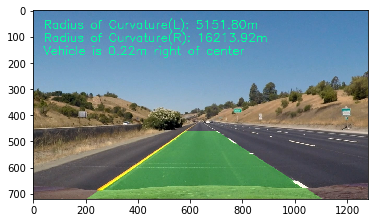

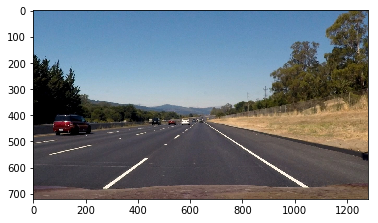

In [698]:
temp_lane.update(mpimg.imread(line_images[0]))
plt.imshow(temp_lane.out_image)
plt.figure()
plt.imshow(mpimg.imread(line_images[1]))

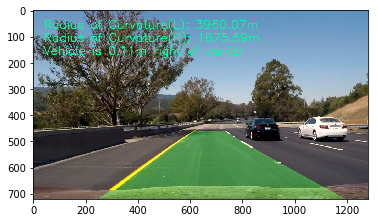

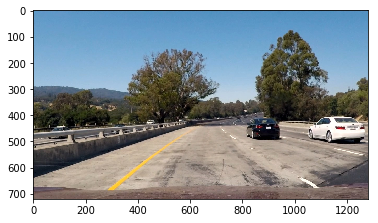

In [699]:
temp_lane.update(mpimg.imread(test_images[5]))
plt.imshow(temp_lane.out_image)
plt.figure()
plt.imshow(mpimg.imread(test_images[0]))

## Test on Videos

In [142]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

In [143]:
lane_container=Lane()

In [713]:
lane_container=Lane()
# lane_container.sliding_window(image)
lane_container.sliding_window(mpimg.imread(line_images[0]))
def process_image(image):
    try:
        if(lane_container.detected==True):
            lane_container.update(image)
            print('complete')
        else:
            lane_container.sliding_window(image)
            print('window-notdetected')
            
    except:
        try:
            lane_container.sliding_window(image) 
            print('window')
        except:
            print('fail')
            pass
        else:
            
            print('fail')
            pass
        
    l_fit_x_int = lane_container.left_line.fitx[image.shape[0]-1]
    r_fit_x_int = lane_container.right_line.fitx[image.shape[0]-1]
    print(l_fit_x_int, r_fit_x_int, r_fit_x_int - l_fit_x_int)
#     print('LFIT',lane_container.left_line.best_fit)
    if ((r_fit_x_int - l_fit_x_int)<400.0 ) and ((r_fit_x_int - l_fit_x_int)>250.0):
        
#         if(abs(R-R0)/R0>0.5)
        if(abs(lane_container.left_line.radius_of_curvature-lane_container.right_line.radius_of_curvature)/ \
           lane_container.right_line.radius_of_curvature <0.3) :
#        abs(R-R0)/R0  # R = current radius of curvature
#             print(lane_container.left_line.best_fit)
#             print('curr',3*lane_container.left_line.current_fit)

            lane_container.left_line.best_fit=lane_container.left_line.current_fit*0.7 + \
                0.3* lane_container.left_line.best_fit
            lane_container.right_line.best_fit= 0.7*lane_container.right_line.current_fit + \
                0.3* lane_container.right_line.current_fit
                
            lane_container.n_fail=0
            lane_container.detected=True
            lane_container.refresh_lines(image)
            
            
        else:
            print('curvature poblem')
#             lane_container.sliding_window(image)
#             lane_container.out_image=image
            lane_container.bootstrap_lane_lines(image)
            print('bootstrap')
            lane_container.n_fail+=1
            lane_container.detected=True
#             update the image using previous configuration
    else:
        print('lane width problem')
        
        if(lane_container.n_fail>5):
            lane_container.detected=False
            lane_container.out_image=image
#         lane_container.detected=False
        else:
            lane_container.bootstrap_lane_lines(image)
            lane_container.n_fail+=1
#     if ()
            
#         l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
#         r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
#         x_int_diff = abs(r_fit_x_int-l_fit_x_int)
#         if abs(350 - x_int_diff) > 100:
#             l_fit = None
#             r_fit = None
            
#     l_line.add_fit(l_fit, l_lane_inds)
#     r_line.add_fit(r_fit, r_lane_inds)
        
#     if (rn.rand()>0.80):
#         lane_container.sliding_window(image)
#     else:
#         lane_container.update(image)
    return lane_container.out_image

SLIDING:CURVATURE TOO DIFFERENT


complete
458.983934891 756.665634001 297.68169911
curvature poblem
bootstrap
[  2.80991482e-05  -9.96008517e-02   5.15368226e+02]
9.15958507827e-11


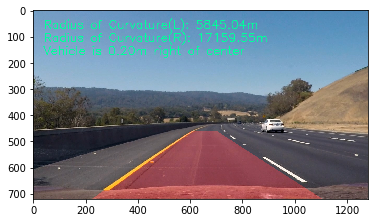

In [707]:
process_image(mpimg.imread(test_images[2]))
plt.imshow(lane_container.out_image)
print(lane_container.left_line.best_fit)
print(lane_container.right_line.best_fit[0]**2)
# plt.imshow(temp_lane.out_image)
# plt.figure()
# plt.imshow(mpimg.imread(test_images[0]))

In [73]:
sample_output = 'sample_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)

[MoviePy] >>>> Building video sample_output.mp4
[MoviePy] Writing video sample_output.mp4


100%|█████████▉| 1260/1261 [02:18<00:00,  9.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sample_output.mp4 

CPU times: user 3min 5s, sys: 21.9 s, total: 3min 27s
Wall time: 2min 18s


In [58]:
video = io.open('sample_output.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [74]:
from numpy import random as rn

In [ ]:
lane_container=Lane()
sample_output = 'sample_trX_update_best_fit_average12.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)

SLIDING:CURVATURE accepted
window-notdetected
476.173985431 775.681161912 299.507176481
curvature poblem
bootstrap
[MoviePy] >>>> Building video sample_trX_update_best_fit_average12.mp4
[MoviePy] Writing video sample_trX_update_best_fit_average12.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

complete
476.173985431 775.681161912 299.507176481
curvature poblem


  0%|          | 1/1261 [00:00<04:09,  5.06it/s]

bootstrap
complete
476.4973907 774.370421026 297.873030325


  0%|          | 3/1261 [00:00<04:02,  5.18it/s]

complete
476.574889413 774.796155906 298.221266493
curvature poblem
bootstrap
complete
477.094439324 775.723674832 298.629235508
curvature poblem


  0%|          | 5/1261 [00:00<03:59,  5.24it/s]

bootstrap
complete
477.524099272 775.263343875 297.739244603
curvature poblem
bootstrap
complete
478.224202197 775.275824305 297.051622107
curvature poblem
bootstrap

  1%|          | 8/1261 [00:01<03:41,  5.66it/s]


complete
479.133879119 775.84806346 296.714184341
curvature poblem
bootstrap
complete
480.170752868 776.945529598 296.77477673
curvature poblem
bootstrap


  1%|          | 10/1261 [00:01<03:29,  5.98it/s]

complete
479.999902243 777.143719134 297.14381689
curvature poblem
bootstrap
complete
479.88970788 776.991834862 297.102126982
curvature poblem
bootstrap


  1%|          | 11/1261 [00:01<03:32,  5.88it/s]

complete
480.05683069 777.288840585 297.232009894
curvature poblem
bootstrap


  1%|          | 12/1261 [00:02<03:56,  5.29it/s]

complete
479.523719513 778.136078649 298.612359136
curvature poblem
bootstrap


  1%|          | 13/1261 [00:02<04:17,  4.84it/s]

complete
479.999346317 776.305199567 296.305853251
curvature poblem
bootstrap


  1%|          | 14/1261 [00:02<04:13,  4.93it/s]

complete
480.300061485 776.047322069 295.747260584
curvature poblem
bootstrap
complete
480.686948066 775.36967355 294.682725484
curvature poblem


  1%|▏         | 16/1261 [00:02<03:58,  5.23it/s]

bootstrap
complete
480.8910395 773.818644963 292.927605462
curvature poblem
bootstrap


  1%|▏         | 17/1261 [00:03<03:53,  5.34it/s]

complete
480.868444687 773.53224587 292.663801183
curvature poblem
bootstrap
complete
480.929618534 773.029640647 292.100022113
curvature poblem
bootstrap

  2%|▏         | 19/1261 [00:03<03:45,  5.51it/s]


complete
480.383140206 773.356775941 292.973635735
curvature poblem
bootstrap
complete
479.901262007 773.155615573 293.254353566


  2%|▏         | 21/1261 [00:03<03:50,  5.39it/s]

complete
479.453959916 770.261744181 290.807784264
complete
478.760201402

  2%|▏         | 23/1261 [00:04<03:52,  5.32it/s]

 769.127760329 290.367558928
curvature poblem
bootstrap
complete
477.426193578 769.431158448 292.00496487


  2%|▏         | 25/1261 [00:04<03:33,  5.80it/s]

complete
476.41350129 769.54121869 293.1277174
complete
475.333444063 767.907205539 292.573761476
curvature poblem
bootstrap


  2%|▏         | 27/1261 [00:04<03:25,  6.00it/s]

complete
474.034296128 768.198291023 294.163994895
curvature poblem
bootstrap
complete
473.045400755 769.695058047 296.649657292


  2%|▏         | 29/1261 [00:05<03:23,  6.04it/s]

complete
471.809699511 771.162915729 299.353216218
complete
471.276472536 771.708716454 300.432243918


  2%|▏         | 31/1261 [00:05<03:22,  6.07it/s]

complete
470.706447087 771.694633812 300.988186725
curvature poblem
bootstrap
complete
470.783744874 771.772648684 300.98890381


  3%|▎         | 33/1261 [00:05<03:26,  5.95it/s]

complete
470.836148545 771.265649105 300.42950056
curvature poblem
bootstrap
complete
470.603546749 773.307178889 302.703632139
curvature poblem
bootstrap


  3%|▎         | 35/1261 [00:06<03:24,  6.01it/s]

complete
470.884670948 772.345799961 301.461129014
complete
471.535880392 773.529080653 301.993200261
curvature poblem
bootstrap


  3%|▎         | 37/1261 [00:06<03:21,  6.07it/s]

complete
472.508700264 773.335890987 300.827190723
curvature poblem
bootstrap
complete
472.668928249 771.003062252 298.334134003
curvature poblem
bootstrap


  3%|▎         | 38/1261 [00:06<03:25,  5.96it/s]

complete
473.244316583 769.888544551 296.644227968
curvature poblem
bootstrap
complete
473.574935542 769.32993079 295.754995248
curvature poblem
bootstrap

  3%|▎         | 40/1261 [00:07<03:29,  5.82it/s]


complete
473.71383241 769.210817609 295.496985199
curvature poblem
bootstrap
complete
474.122828377 770.155687611 296.032859234
curvature poblem
bootstrap

  3%|▎         | 42/1261 [00:07<03:33,  5.71it/s]


complete
474.615669531 770.610296477 295.994626946
curvature poblem
bootstrap
complete
474.970251065 771.541551228 296.571300164
curvature poblem


  3%|▎         | 44/1261 [00:07<03:29,  5.80it/s]

bootstrap
complete
475.073710505 771.37068507 296.296974565
curvature poblem
bootstrap


  4%|▎         | 46/1261 [00:08<03:23,  5.97it/s]

complete
475.479742625 772.400468217 296.920725593
curvature poblem
bootstrap
complete
475.406458106 778.052182332 302.645724226
curvature poblem
bootstrap


  4%|▎         | 47/1261 [00:08<03:18,  6.13it/s]

complete
475.705612557 771.393254913 295.687642356
complete
476.036408485 771.430538244 295.394129759
curvature poblem
bootstrap


  4%|▍         | 49/1261 [00:08<03:25,  5.88it/s]

complete
476.232391598 772.025621647 295.79323005
complete
476.638274485 770.257410368 293.619135882


  4%|▍         | 52/1261 [00:09<03:25,  5.88it/s]

complete
476.961728344 771.031912174 294.07018383
complete
477.606613636 770.232163057 292.625549421


  4%|▍         | 54/1261 [00:09<03:21,  5.99it/s]

complete
477.865351949 769.944730286 292.079378337
complete
477.68460491 770.22062466 292.53601975


  4%|▍         | 55/1261 [00:09<03:21,  5.98it/s]

complete
477.895169975 770.87779243 292.982622455
complete
477.741883078 770.987289954 293.245406876


  5%|▍         | 58/1261 [00:10<03:17,  6.09it/s]

complete
477.622116074 771.41226405 293.790147975
curvature poblem
bootstrap
complete
477.264543968 771.393487608 294.12894364
curvature poblem
bootstrap


  5%|▍         | 60/1261 [00:10<03:14,  6.18it/s]

complete
476.974590854 771.409178192 294.434587337
complete
476.523608826 769.482614007 292.95900518


  5%|▍         | 62/1261 [00:10<03:13,  6.21it/s]

complete
475.673239901 768.723620693 293.050380792
complete
475.071238291 767.599479654 292.528241363


  5%|▌         | 64/1261 [00:11<03:12,  6.23it/s]

complete
473.992310549 765.860458071 291.868147522
complete
473.138531534 765.6023543 292.463822766


  5%|▌         | 66/1261 [00:11<03:08,  6.36it/s]

complete
471.908135937 766.044911097 294.13677516
complete
471.346542278 765.733075105 294.386532826
curvature poblem
bootstrap


  5%|▌         | 68/1261 [00:11<03:05,  6.43it/s]

complete
470.472773962 765.372953419 294.900179457
curvature poblem
bootstrap
complete
469.547427145 765.286969773 295.739542628
curvature poblem
bootstrap


  6%|▌         | 70/1261 [00:12<03:08,  6.33it/s]

complete
469.406179625 764.719547735 295.31336811
curvature poblem
bootstrap
complete
469.162896993 764.598139872 295.435242878
curvature poblem
bootstrap


  6%|▌         | 72/1261 [00:12<03:07,  6.33it/s]

complete
469.404532423 763.757992476 294.353460053
curvature poblem
bootstrap
complete
469.333514535 763.998902139 294.665387604
curvature poblem
bootstrap


  6%|▌         | 74/1261 [00:12<03:10,  6.24it/s]

complete
469.401861972 763.366977727 293.965115756
curvature poblem
bootstrap
complete
469.853796897 761.991113475 292.137316577
curvature poblem
bootstrap


  6%|▌         | 76/1261 [00:12<03:12,  6.14it/s]

complete
469.310818756 759.862698889 290.551880133
complete
469.868250682 758.658591928 288.790341247
curvature poblem
bootstrap


  6%|▌         | 77/1261 [00:13<03:16,  6.01it/s]

complete
469.295346605 759.63014842 290.334801815
curvature poblem
bootstrap
complete
468.966152432 760.431284321 291.46513189
curvature poblem


  6%|▋         | 79/1261 [00:13<03:25,  5.75it/s]

bootstrap
complete
468.36057173 760.825692855 292.465121125
curvature poblem
bootstrap


  6%|▋         | 80/1261 [00:13<03:27,  5.68it/s]

complete
467.540743437 760.695300943 293.154557505
curvature poblem
bootstrap
complete
466.776126008 760.178251521 293.402125513
curvature poblem
bootstrap


  7%|▋         | 83/1261 [00:14<03:21,  5.86it/s]

complete
465.612711038 759.839506098 294.22679506
curvature poblem
bootstrap
complete
464.508670831 760.691684533 296.183013703
curvature poblem
bootstrap


  7%|▋         | 85/1261 [00:14<03:15,  6.03it/s]

complete
462.863806139 761.707763165 298.843957027
curvature poblem
bootstrap
complete
461.820983222 761.96521618 300.144232958
curvature poblem
bootstrap


  7%|▋         | 86/1261 [00:14<03:18,  5.91it/s]

complete
460.713241562 762.458495594 301.745254032
curvature poblem
bootstrap
complete
460.829695678 760.758997086 299.929301408


  7%|▋         | 88/1261 [00:15<03:25,  5.71it/s]

complete
460.679166737 759.280783121 298.601616384
complete
460.253084088 759.247794648 298.99471056


  7%|▋         | 91/1261 [00:15<03:17,  5.91it/s]

complete
461.213476536 758.338779129 297.125302593
complete
461.168085041 759.334124989 298.166039948


  7%|▋         | 92/1261 [00:15<03:25,  5.68it/s]

complete
461.47592295 759.942844268 298.466921318
curvature poblem
bootstrap
complete
462.064484817 760.020474513 297.955989696
curvature poblem


  7%|▋         | 94/1261 [00:16<03:26,  5.66it/s]

bootstrap
complete
462.534550341 759.852634007 297.318083666
curvature poblem
bootstrap


  8%|▊         | 95/1261 [00:16<03:28,  5.59it/s]

complete
462.549294732 759.108483515 296.559188783
curvature poblem
bootstrap
complete
462.764185694 756.698329261 293.934143567


  8%|▊         | 97/1261 [00:16<03:28,  5.59it/s]

complete
463.419457694 754.915511106 291.496053412
complete
463.605608769 756.664138072 293.058529302


  8%|▊         | 100/1261 [00:17<03:18,  5.86it/s]

complete
464.436048961 755.734296634 291.298247672
complete
464.727981845 752.531287827 287.803305982


  8%|▊         | 102/1261 [00:17<03:11,  6.05it/s]

complete
465.492404079 753.932810562 288.440406483
complete
466.124682501 753.951606238 287.826923737


  8%|▊         | 103/1261 [00:17<03:13,  6.00it/s]

complete
466.354060968 755.274302182 288.920241213
complete
467.000548795 756.514040654 289.513491859


  8%|▊         | 106/1261 [00:18<03:10,  6.06it/s]

complete
466.911141656 758.470201583 291.559059927
complete
467.171830769 759.727883791 292.556053022


  8%|▊         | 107/1261 [00:18<03:09,  6.10it/s]

complete
467.247456256 761.37847828 294.131022024
complete
467.825406395 762.379265151 294.553858756


  9%|▊         | 110/1261 [00:18<03:11,  6.00it/s]

complete
467.88189513 766.073725028 298.191829898
curvature poblem
bootstrap
complete
467.856740379 764.996268521 297.139528142
curvature poblem
bootstrap


  9%|▉         | 112/1261 [00:19<03:08,  6.10it/s]

complete
468.062907331 765.29807287 297.235165539
curvature poblem
bootstrap
complete
467.896029524 765.701161416 297.805131892
curvature poblem
bootstrap


  9%|▉         | 113/1261 [00:19<03:08,  6.08it/s]

complete
468.535835979 764.659377395 296.123541416
curvature poblem
bootstrap
complete
468.713105819 765.085963792 296.372857974
curvature poblem
bootstrap


  9%|▉         | 115/1261 [00:19<03:11,  5.98it/s]

complete
469.503797818 764.972553608 295.46875579
curvature poblem
bootstrap
complete
469.555988839 763.816707774 294.260718935
curvature poblem
bootstrap


  9%|▉         | 118/1261 [00:20<03:11,  5.97it/s]

complete
469.785206717 764.558776869 294.773570152
curvature poblem
bootstrap
complete
470.540801135 764.6541983 294.113397165
curvature poblem
bootstrap


 10%|▉         | 120/1261 [00:20<03:07,  6.10it/s]

complete
470.782775711 764.790484608 294.007708897
curvature poblem
bootstrap
complete
471.573510175 764.826411134 293.252900959
curvature poblem
bootstrap


 10%|▉         | 122/1261 [00:20<03:07,  6.08it/s]

complete
472.179628977 765.9835792 293.803950223
curvature poblem
bootstrap
complete
472.71477327 769.293934376 296.579161106
curvature poblem
bootstrap


 10%|▉         | 123/1261 [00:20<03:08,  6.05it/s]

complete
473.40140844 764.804082305 291.402673865
complete
473.830780264 764.405868029 290.575087766


 10%|▉         | 125/1261 [00:21<03:13,  5.88it/s]

complete
474.692795225 763.688055569 288.995260344
complete
474.925450705 764.887089253 289.961638547


 10%|█         | 127/1261 [00:21<03:15,  5.79it/s]

complete
475.174469607 765.403138656 290.228669049
complete
475.612257244 766.486596483 290.87433924


 10%|█         | 130/1261 [00:22<03:13,  5.86it/s]

complete
476.639271908 767.217011909 290.577740001
complete
476.860907076 767.650088886 290.78918181


 10%|█         | 132/1261 [00:22<03:08,  5.98it/s]

complete
477.322700232 768.155494546 290.832794314
complete
477.887704241 768.548438945 290.660734704


 11%|█         | 134/1261 [00:22<03:07,  6.00it/s]

complete
478.357580984 769.729854418 291.372273434
complete
479.141079031 773.06686335 293.925784319
curvature poblem
bootstrap


 11%|█         | 136/1261 [00:23<03:05,  6.07it/s]

complete
479.815271502 771.42999827 291.614726767
complete
479.99439714 771.748482928 291.754085789


 11%|█         | 138/1261 [00:23<03:03,  6.11it/s]

complete
479.821747605 771.651102224 291.829354619
complete
479.335014028 771.211245721 291.876231692


 11%|█         | 140/1261 [00:23<03:01,  6.19it/s]

complete
478.83832199 771.436153255 292.597831265
complete
478.148004606 772.033416507 293.885411901


 11%|█▏        | 142/1261 [00:24<02:59,  6.25it/s]

complete
477.78113213 772.489999062 294.708866932
complete
477.539295066 772.66362967 295.124334604


 11%|█▏        | 144/1261 [00:24<02:59,  6.24it/s]

complete
477.43887118 772.449777461 295.010906282
curvature poblem
bootstrap
complete
477.021947233 771.234103691 294.212156458


 11%|█▏        | 145/1261 [00:24<03:03,  6.08it/s]

complete
476.713253025 771.941879322 295.228626297
complete
476.780877539 771.954932366 295.174054827


 12%|█▏        | 147/1261 [00:24<03:10,  5.83it/s]

complete
476.923999037 776.347075504 299.423076467
curvature poblem
bootstrap
complete
477.718964699 777.400279745 299.681315046
curvature poblem
bootstrap


 12%|█▏        | 149/1261 [00:25<03:13,  5.74it/s]

complete
477.881822809 774.063687116 296.181864307
curvature poblem
bootstrap
complete
478.06375268 771.774905335 293.711152656
curvature poblem


 12%|█▏        | 151/1261 [00:25<03:22,  5.49it/s]

bootstrap
complete
477.633778948 770.118438634 292.484659686


 12%|█▏        | 153/1261 [00:26<03:13,  5.73it/s]

complete
477.031321244 770.415588822 293.384267578
curvature poblem
bootstrap
complete
477.12405775 768.94105725 291.8169995


 12%|█▏        | 155/1261 [00:26<03:06,  5.93it/s]

complete
476.341861577 769.991827258 293.649965681
curvature poblem
bootstrap
complete
475.875938213 770.63171027 294.755772057
curvature poblem
bootstrap


 12%|█▏        | 157/1261 [00:26<03:04,  5.98it/s]

complete
475.220948744 770.161611318 294.940662574
curvature poblem
bootstrap
complete
474.474171117 769.26277285 294.788601733


 13%|█▎        | 159/1261 [00:27<03:01,  6.09it/s]

complete
473.814895299 768.129161787 294.314266488
complete
472.932727416 769.328257475 296.395530059


 13%|█▎        | 161/1261 [00:27<03:03,  5.99it/s]

complete
472.368049386 768.729404452 296.361355067
complete
471.722727195 769.498758601 297.776031406


 13%|█▎        | 163/1261 [00:27<03:01,  6.04it/s]

complete
471.125951617 769.197894869 298.071943252
complete
470.498366219 770.66456296 300.166196741
curvature poblem
bootstrap


 13%|█▎        | 165/1261 [00:28<03:00,  6.08it/s]

complete
470.573304904 770.417986132 299.844681228
curvature poblem
bootstrap
complete
470.682718491 769.164004994 298.481286504
curvature poblem
bootstrap


 13%|█▎        | 166/1261 [00:28<03:01,  6.04it/s]

complete
470.52433291 768.99110648 298.466773569
curvature poblem
bootstrap
complete
470.777023298 768.650977078 297.873953781
curvature poblem


 13%|█▎        | 168/1261 [00:28<03:04,  5.92it/s]

bootstrap
complete
470.507253524 769.341473536 298.834220012
curvature poblem
bootstrap


 13%|█▎        | 170/1261 [00:28<03:04,  5.90it/s]

complete
470.378286191 769.317539055 298.939252863
curvature poblem
bootstrap
complete
469.642107263 769.234825898 299.592718635
curvature poblem
bootstrap


 14%|█▎        | 171/1261 [00:29<03:07,  5.81it/s]

complete
469.397944735 775.676498445 306.278553709
complete
469.162451669 769.91701734 300.754565671
curvature poblem


 14%|█▎        | 173/1261 [00:29<03:15,  5.56it/s]

bootstrap
complete
469.025943731 770.612247269 301.586303538


 14%|█▍        | 174/1261 [00:29<03:21,  5.41it/s]

complete
468.958099456 763.937989553 294.979890097
curvature poblem
bootstrap
complete
468.976472111 758.583398971 289.60692686
curvature poblem


 14%|█▍        | 176/1261 [00:29<03:11,  5.66it/s]

bootstrap
complete
468.467199025 759.260136213 290.792937188
curvature poblem
bootstrap


 14%|█▍        | 178/1261 [00:30<03:01,  5.95it/s]

complete
467.870627701 760.088100965 292.217473264
curvature poblem
bootstrap
complete
467.541444414 761.572879911 294.031435497
curvature poblem
bootstrap


 14%|█▍        | 180/1261 [00:30<02:57,  6.09it/s]

complete
466.818245501 763.250714394 296.432468893
curvature poblem
bootstrap
complete
466.504240647 765.449704709 298.945464062


 14%|█▍        | 182/1261 [00:30<03:00,  5.99it/s]

complete
465.686371706 765.444349502 299.757977797
curvature poblem
bootstrap
complete
464.576479623 766.173954652 301.597475029
curvature poblem
bootstrap


 15%|█▍        | 183/1261 [00:31<03:04,  5.85it/s]

complete
464.110486215 766.949798364 302.839312148
curvature poblem
bootstrap
complete
463.806990753 770.439782837 306.632792084


 15%|█▍        | 186/1261 [00:31<03:00,  5.94it/s]

complete
463.466955452 769.478183429 306.011227976
complete
463.969887432 768.636596577 304.666709145


 15%|█▍        | 187/1261 [00:31<03:04,  5.81it/s]

complete
464.236306702 765.340764526 301.104457823
complete
464.940479789 765.939902516 300.999422727


 15%|█▍        | 189/1261 [00:32<03:09,  5.64it/s]

complete
465.913127418 765.884538648 299.97141123
complete
467.119008776 766.961929706 299.84292093


 15%|█▌        | 191/1261 [00:32<03:13,  5.54it/s]

complete
468.631780953 767.167959955 298.536179002
complete
470.022625372 768.205223364 298.182597992


 15%|█▌        | 193/1261 [00:32<03:11,  5.57it/s]

complete
471.722846848 768.600763957 296.877917109
curvature poblem
bootstrap
complete
473.055145422 768.423233996 295.368088574


 16%|█▌        | 196/1261 [00:33<03:02,  5.84it/s]

complete
473.314294064 769.185201893 295.870907828
complete
472.703126037 774.270478746 301.567352708
curvature poblem
bootstrap


 16%|█▌        | 198/1261 [00:33<02:58,  5.94it/s]

complete
471.439453018 774.023054601 302.583601583
curvature poblem
bootstrap
complete
470.283899006 771.655834722 301.371935715
curvature poblem
bootstrap


 16%|█▌        | 200/1261 [00:34<02:54,  6.09it/s]

complete
469.262621342 771.762660636 302.500039294
complete
469.081722442 770.971614351 301.889891909


 16%|█▌        | 201/1261 [00:34<02:53,  6.10it/s]

complete
468.223704089 770.568883519 302.345179431
complete
467.717932908 770.180794979 302.462862072


 16%|█▌        | 204/1261 [00:34<02:56,  5.98it/s]

complete
467.442463244 769.614815229 302.172351986
complete
466.928924916 769.7220235 302.793098584
curvature poblem
bootstrap


 16%|█▋        | 206/1261 [00:35<02:51,  6.15it/s]

complete
467.141015831 768.714035891 301.573020061
curvature poblem
bootstrap
complete
467.133480364 768.41666763 301.283187266


 16%|█▋        | 208/1261 [00:35<02:47,  6.28it/s]

complete
467.750801116 767.948511913 300.197710797
complete
468.192997135 769.415074937 301.222077802
curvature poblem
bootstrap


 17%|█▋        | 210/1261 [00:35<02:46,  6.32it/s]

complete
468.176877726 770.825828081 302.648950355
curvature poblem
bootstrap
complete
468.069319077 770.953687205 302.884368128
curvature poblem
bootstrap


 17%|█▋        | 212/1261 [00:36<02:50,  6.16it/s]

complete
467.379672717 769.999656364 302.619983646
complete
467.351979626 769.507992093 302.156012467


 17%|█▋        | 214/1261 [00:36<02:51,  6.09it/s]

complete
466.801431417 767.863331553 301.061900136
complete
466.667713733 766.754640476 300.086926743


 17%|█▋        | 216/1261 [00:36<02:53,  6.03it/s]

complete
466.031694369 765.562108591 299.530414222
complete
465.779927235 765.91191677 300.131989535


 17%|█▋        | 218/1261 [00:37<02:52,  6.04it/s]

complete
465.624561067 765.499956395 299.875395329
curvature poblem
bootstrap
complete
465.272763917 764.687238797 299.41447488


 17%|█▋        | 219/1261 [00:37<02:55,  5.95it/s]

complete
465.676972066 764.287888768 298.610916703
complete
465.602786378 764.53368196 298.930895582


 18%|█▊        | 222/1261 [00:37<02:51,  6.04it/s]

complete
466.410742821 768.525129448 302.114386627
curvature poblem
bootstrap
complete
466.592816171 767.634389184 301.041573013
curvature poblem
bootstrap


 18%|█▊        | 223/1261 [00:37<02:52,  6.01it/s]

complete
466.566997456 768.233738374 301.666740918
curvature poblem
bootstrap
complete
467.126085973 766.789243768 299.663157795
curvature poblem


 18%|█▊        | 225/1261 [00:38<02:56,  5.87it/s]

bootstrap
complete
466.658720661 765.135394856 298.476674195
curvature poblem
bootstrap


 18%|█▊        | 227/1261 [00:38<02:54,  5.93it/s]

complete
466.595170373 763.123672978 296.528502605
curvature poblem
bootstrap
complete
466.133870582 761.718975034 295.585104452
curvature poblem
bootstrap


 18%|█▊        | 228/1261 [00:38<02:56,  5.84it/s]

complete
465.436188242 761.172654761 295.736466519
curvature poblem
bootstrap
complete
465.033484612 760.480102488 295.446617876
curvature poblem


 18%|█▊        | 230/1261 [00:39<02:58,  5.78it/s]

bootstrap
complete
464.258383604 759.438391382 295.180007777
curvature poblem
bootstrap


 18%|█▊        | 232/1261 [00:39<02:53,  5.93it/s]

complete
463.996616137 758.230254766 294.233638629
curvature poblem
bootstrap
complete
462.9879749 757.632518781 294.644543881
curvature poblem
bootstrap


 18%|█▊        | 233/1261 [00:39<02:53,  5.93it/s]

complete
462.43142353 760.373730022 297.942306491
curvature poblem
bootstrap
complete
461.733218019 756.134345841 294.401127823


 19%|█▊        | 235/1261 [00:39<03:00,  5.67it/s]

complete
460.795116812 755.942213288 295.147096476


 19%|█▊        | 236/1261 [00:40<03:09,  5.41it/s]

complete
460.446228108 754.841840623 294.395612515
complete
459.772048273 752.168628404 292.396580131
curvature poblem


 19%|█▉        | 238/1261 [00:40<03:05,  5.52it/s]

bootstrap
complete
459.322542943 752.284623239 292.962080296
curvature poblem
bootstrap


 19%|█▉        | 239/1261 [00:40<03:01,  5.63it/s]

complete
458.781839777 752.417109324 293.635269547
complete
458.236143352 752.960478224 294.724334872


 19%|█▉        | 242/1261 [00:41<02:56,  5.78it/s]

complete
457.813806194 753.176601897 295.362795703
complete
456.721336253 753.93189662 297.210560366


 19%|█▉        | 243/1261 [00:41<02:56,  5.77it/s]

complete
456.520301709 753.474636042 296.954334332
complete
455.803364716 753.164892647 297.361527932


 19%|█▉        | 245/1261 [00:41<03:07,  5.42it/s]

complete
455.45319946 756.735557559 301.282358099
curvature poblem
bootstrap
complete
455.111569396 756.406024287 301.294454892
curvature poblem


 20%|█▉        | 246/1261 [00:41<03:03,  5.54it/s]

bootstrap
complete
454.513415932 750.595143235 296.081727303


 20%|█▉        | 248/1261 [00:42<03:17,  5.13it/s]

complete
454.898220777 750.730283668 295.832062891
complete
454.354001917 752.143738746 297.789736829


 20%|█▉        | 250/1261 [00:42<03:07,  5.38it/s]

complete
454.599303731 751.597697298 296.998393568
complete
454.513334735 751.730207345 297.21687261


 20%|██        | 253/1261 [00:43<02:54,  5.77it/s]

complete
454.473593755 752.042069987 297.568476232
complete
454.614871906 751.802525067 297.187653161


 20%|██        | 255/1261 [00:43<02:50,  5.89it/s]

complete
454.512402067 752.516646536 298.004244469
complete
454.79241821 752.456333815 297.663915604


 20%|██        | 257/1261 [00:43<02:47,  6.00it/s]

complete
454.53211445 752.429454436 297.897339986
complete
454.790429378 754.615346248 299.82491687


 20%|██        | 258/1261 [00:44<02:49,  5.92it/s]

complete
455.047126135 753.169033322 298.121907187
complete
455.074930775 754.092472507 299.017541732


 21%|██        | 260/1261 [00:44<03:11,  5.22it/s]

complete
455.948341969 751.347986929 295.39964496


 21%|██        | 261/1261 [00:44<03:48,  4.38it/s]

complete
456.065752865 751.838186766 295.772433902


 21%|██        | 262/1261 [00:45<04:28,  3.72it/s]

complete
456.60509187 752.202762771 295.597670901


 21%|██        | 263/1261 [00:45<04:22,  3.80it/s]

complete
456.697864947 751.636661757 294.93879681
curvature poblem
bootstrap


 21%|██        | 264/1261 [00:45<04:20,  3.82it/s]

complete
456.381842438 752.474263072 296.092420635


 21%|██        | 265/1261 [00:45<04:15,  3.91it/s]

complete
456.114588153 753.185775931 297.071187778


 21%|██        | 266/1261 [00:46<04:14,  3.91it/s]

complete
455.319418797 754.57498014 299.255561342


 21%|██        | 267/1261 [00:46<04:12,  3.94it/s]

complete
455.484932717 754.945183919 299.460251202


 21%|██▏       | 268/1261 [00:46<04:10,  3.96it/s]

complete
455.167449755 754.872039055 299.7045893
curvature poblem
bootstrap


 21%|██▏       | 269/1261 [00:46<04:17,  3.85it/s]

complete
454.416663782 756.301659807 301.884996026


 21%|██▏       | 270/1261 [00:47<04:15,  3.87it/s]

complete
454.399347649 759.999781579 305.60043393


 21%|██▏       | 271/1261 [00:47<04:14,  3.90it/s]

complete
455.018328124 759.048563984 304.03023586


 22%|██▏       | 272/1261 [00:47<04:23,  3.75it/s]

complete
455.887989035 758.65519631 302.767207275


 22%|██▏       | 273/1261 [00:48<04:33,  3.61it/s]

complete
456.27712858 758.096286186 301.819157606


 22%|██▏       | 274/1261 [00:48<04:27,  3.69it/s]

complete
457.084343914 757.888692492 300.804348578
curvature poblem
bootstrap


 22%|██▏       | 275/1261 [00:48<04:16,  3.84it/s]

complete
457.460542392 758.144665063 300.684122671
curvature poblem
bootstrap


 22%|██▏       | 276/1261 [00:48<04:15,  3.85it/s]

complete
457.67571793 758.858928464 301.183210534
curvature poblem
bootstrap


 22%|██▏       | 277/1261 [00:49<04:12,  3.90it/s]

complete
457.823692261 758.889066509 301.065374249
curvature poblem
bootstrap


 22%|██▏       | 278/1261 [00:49<04:09,  3.94it/s]

complete
457.955541741 759.510601606 301.555059865
curvature poblem
bootstrap


 22%|██▏       | 279/1261 [00:49<04:03,  4.03it/s]

complete
458.886807092 758.236074849 299.349267758


 22%|██▏       | 280/1261 [00:49<04:06,  3.97it/s]

complete
459.050307748 758.305110994 299.254803246


 22%|██▏       | 281/1261 [00:50<04:21,  3.74it/s]

complete
459.627891732 758.628346121 299.000454389


 22%|██▏       | 282/1261 [00:50<04:29,  3.63it/s]

complete
460.405755103 759.267079638 298.861324534


 22%|██▏       | 283/1261 [00:50<05:26,  2.99it/s]

complete
460.802491978 759.76442229 298.961930312


 23%|██▎       | 284/1261 [00:51<05:59,  2.72it/s]

complete
461.80845589 760.696504191 298.888048301


 23%|██▎       | 285/1261 [00:51<06:35,  2.47it/s]

complete
462.133319836 760.380344 298.247024164


 23%|██▎       | 286/1261 [00:52<06:41,  2.43it/s]

complete
462.31026363 762.017261528 299.706997898


 23%|██▎       | 287/1261 [00:52<07:20,  2.21it/s]

complete
462.858681804 762.491412268 299.632730464


 23%|██▎       | 288/1261 [00:53<06:59,  2.32it/s]

complete
462.846547401 763.445319502 300.598772101


 23%|██▎       | 289/1261 [00:53<06:08,  2.64it/s]

complete
463.904318477 763.505775831 299.601457353
curvature poblem
bootstrap


 23%|██▎       | 290/1261 [00:53<05:36,  2.88it/s]

complete
464.035918371 764.167008399 300.131090028
curvature poblem
bootstrap


 23%|██▎       | 291/1261 [00:54<06:03,  2.67it/s]

complete
464.732249204 763.95424181 299.221992606
curvature poblem
bootstrap


 23%|██▎       | 292/1261 [00:54<06:34,  2.46it/s]

complete
465.422554533 763.991133543 298.568579011
curvature poblem
bootstrap


 23%|██▎       | 293/1261 [00:55<07:03,  2.29it/s]

complete
465.7208423 763.363385368 297.642543068


 23%|██▎       | 294/1261 [00:55<06:38,  2.43it/s]

complete
466.505009685 764.707535519 298.202525834


 23%|██▎       | 295/1261 [00:55<06:13,  2.59it/s]

complete
466.650038602 764.067515695 297.417477093


 23%|██▎       | 296/1261 [00:56<05:37,  2.86it/s]

complete
466.957438267 762.258332434 295.300894167
curvature poblem
bootstrap


 24%|██▎       | 297/1261 [00:56<05:12,  3.08it/s]

complete
466.557109321 762.847570599 296.290461278


 24%|██▎       | 298/1261 [00:56<05:44,  2.79it/s]

complete
466.565555026 763.401154213 296.835599188


 24%|██▎       | 299/1261 [00:56<05:17,  3.03it/s]

complete
466.742503205 763.542319534 296.799816329


 24%|██▍       | 300/1261 [00:57<05:12,  3.07it/s]

complete
466.018145375 764.514547147 298.496401772


 24%|██▍       | 301/1261 [00:57<04:56,  3.24it/s]

complete
466.199762191 764.880372087 298.680609896


 24%|██▍       | 302/1261 [00:57<04:33,  3.50it/s]

complete
465.556231585 765.63461293 300.078381345
curvature poblem
bootstrap


 24%|██▍       | 303/1261 [00:58<04:27,  3.58it/s]

complete
465.422492017 765.56283238 300.140340363


 24%|██▍       | 304/1261 [00:58<04:22,  3.65it/s]

complete
465.320802323 765.500577201 300.179774878


 24%|██▍       | 305/1261 [00:58<04:15,  3.74it/s]

complete
465.1383946 767.871946235 302.733551635


 24%|██▍       | 306/1261 [00:58<04:16,  3.72it/s]

complete
465.852774699 766.135434225 300.282659525


 24%|██▍       | 307/1261 [00:59<04:12,  3.78it/s]

complete
465.955295024 769.224552873 303.269257848
curvature poblem
bootstrap


 24%|██▍       | 308/1261 [00:59<04:10,  3.80it/s]

complete
467.084053627 768.001500107 300.91744648


 25%|██▍       | 309/1261 [00:59<04:03,  3.91it/s]

complete
467.449325564 768.925197135 301.475871571
curvature poblem
bootstrap


 25%|██▍       | 310/1261 [00:59<04:11,  3.79it/s]

complete
467.640413388 767.697924958 300.05751157
curvature poblem
bootstrap


 25%|██▍       | 311/1261 [01:00<04:12,  3.76it/s]

complete
468.363111244 766.507575765 298.144464521
curvature poblem
bootstrap


 25%|██▍       | 312/1261 [01:00<04:10,  3.78it/s]

complete
468.66749704 766.130195216 297.462698177
curvature poblem
bootstrap


 25%|██▍       | 313/1261 [01:00<04:07,  3.83it/s]

complete
469.753339599 765.476322892 295.722983294


 25%|██▍       | 314/1261 [01:00<04:12,  3.76it/s]

complete
469.614817243 765.567296865 295.952479622


 25%|██▍       | 315/1261 [01:01<04:11,  3.76it/s]

complete
469.576323335 765.290052606 295.713729271


 25%|██▌       | 316/1261 [01:01<04:11,  3.76it/s]

complete
469.659014853 765.392429272 295.733414419


 25%|██▌       | 317/1261 [01:01<04:07,  3.81it/s]

complete
470.015890725 770.203344752 300.187454027
curvature poblem
bootstrap


 25%|██▌       | 318/1261 [01:02<04:09,  3.77it/s]

complete
470.65656778 764.992582394 294.336014614


 25%|██▌       | 319/1261 [01:02<04:06,  3.83it/s]

complete
470.496899562 763.430777508 292.933877946
curvature poblem
bootstrap


 25%|██▌       | 320/1261 [01:02<04:01,  3.90it/s]

complete
471.070755185 761.82672754 290.755972355


 25%|██▌       | 321/1261 [01:02<04:01,  3.89it/s]

complete
471.249931262 761.611424089 290.361492827
curvature poblem
bootstrap


 26%|██▌       | 322/1261 [01:03<04:03,  3.86it/s]

complete
471.413460837 761.473260091 290.059799255
curvature poblem
bootstrap


 26%|██▌       | 323/1261 [01:03<04:05,  3.83it/s]

complete
471.852760339 761.424332941 289.571572602
curvature poblem
bootstrap


 26%|██▌       | 324/1261 [01:03<03:58,  3.93it/s]

complete
471.285046186 763.004878168 291.719831982
curvature poblem
bootstrap


 26%|██▌       | 325/1261 [01:03<03:58,  3.92it/s]

complete
471.486581162 762.652272346 291.165691184
curvature poblem
bootstrap


 26%|██▌       | 326/1261 [01:04<04:01,  3.88it/s]

complete
471.098235126 763.457946042 292.359710916
curvature poblem
bootstrap


 26%|██▌       | 327/1261 [01:04<04:03,  3.84it/s]

complete
470.428084582 763.940377542 293.512292961


 26%|██▌       | 328/1261 [01:04<04:00,  3.88it/s]

complete
469.953713996 764.083594571 294.129880575
curvature poblem
bootstrap


 26%|██▌       | 329/1261 [01:04<04:00,  3.87it/s]

complete
468.593915524 765.751095843 297.157180318
curvature poblem
bootstrap


 26%|██▌       | 330/1261 [01:05<04:06,  3.78it/s]

complete
469.264748408 764.45577115 295.191022742
curvature poblem
bootstrap


 26%|██▌       | 331/1261 [01:05<04:03,  3.82it/s]

complete
468.792534098 766.595775715 297.803241617
curvature poblem
bootstrap


 26%|██▋       | 332/1261 [01:05<04:03,  3.81it/s]

complete
469.499008676 764.563436891 295.064428215
curvature poblem
bootstrap


 26%|██▋       | 333/1261 [01:05<04:00,  3.86it/s]

complete
469.544230162 764.212589261 294.668359099
curvature poblem
bootstrap


 26%|██▋       | 334/1261 [01:06<04:00,  3.86it/s]

complete
469.545443072 763.394772679 293.849329607
curvature poblem
bootstrap


 27%|██▋       | 335/1261 [01:06<03:57,  3.89it/s]

complete
469.635139709 764.19287522 294.557735511
curvature poblem
bootstrap


 27%|██▋       | 336/1261 [01:06<03:56,  3.91it/s]

complete
469.266437545 765.116272318 295.849834773
curvature poblem
bootstrap


 27%|██▋       | 337/1261 [01:06<03:51,  4.00it/s]

complete
469.136003141 765.879009247 296.743006107
curvature poblem
bootstrap


 27%|██▋       | 338/1261 [01:07<04:00,  3.84it/s]

complete
469.22091105 766.429346902 297.208435852


 27%|██▋       | 339/1261 [01:07<03:55,  3.92it/s]

complete
469.366996415 766.542874883 297.175878468
curvature poblem
bootstrap


 27%|██▋       | 340/1261 [01:07<03:51,  3.98it/s]

complete
469.354798337 766.538183313 297.183384977
curvature poblem
bootstrap


 27%|██▋       | 341/1261 [01:07<03:49,  4.02it/s]

complete
469.77328948 767.971447451 298.198157971
curvature poblem
bootstrap


 27%|██▋       | 342/1261 [01:08<03:53,  3.93it/s]

complete
470.907880856 766.517139928 295.609259072
curvature poblem
bootstrap


 27%|██▋       | 343/1261 [01:08<03:54,  3.91it/s]

complete
470.953207065 766.492799912 295.539592848
curvature poblem
bootstrap


 27%|██▋       | 344/1261 [01:08<03:51,  3.97it/s]

complete
470.771673155 764.372182852 293.600509697
curvature poblem
bootstrap


 27%|██▋       | 345/1261 [01:08<03:49,  3.99it/s]

complete
471.090812165 765.557546268 294.466734104
curvature poblem
bootstrap


 27%|██▋       | 346/1261 [01:09<03:49,  3.98it/s]

complete
471.305476465 766.208898553 294.903422088
curvature poblem
bootstrap


 28%|██▊       | 347/1261 [01:09<03:47,  4.02it/s]

complete
471.806452851 764.762785543 292.956332692
curvature poblem
bootstrap


 28%|██▊       | 348/1261 [01:09<03:44,  4.06it/s]

complete
471.60489896 765.927711475 294.322812515


 28%|██▊       | 349/1261 [01:09<03:48,  3.98it/s]

complete
471.698145872 765.173550182 293.47540431
curvature poblem
bootstrap


 28%|██▊       | 350/1261 [01:10<03:47,  4.01it/s]

complete
471.07032712 765.867867302 294.797540183
curvature poblem
bootstrap


 28%|██▊       | 351/1261 [01:10<03:43,  4.08it/s]

complete
470.930979199 766.063952022 295.132972823
curvature poblem
bootstrap


 28%|██▊       | 352/1261 [01:10<03:39,  4.14it/s]

complete
470.155841401 766.254751838 296.098910437
curvature poblem
bootstrap


 28%|██▊       | 353/1261 [01:10<03:40,  4.12it/s]

complete
469.137925877 767.119798789 297.981872913
curvature poblem
bootstrap


 28%|██▊       | 354/1261 [01:11<03:53,  3.89it/s]

complete
468.534119356 765.516343376 296.982224021
curvature poblem
bootstrap


 28%|██▊       | 355/1261 [01:11<03:58,  3.80it/s]

complete
467.830782269 765.902273436 298.071491168
curvature poblem
bootstrap


 28%|██▊       | 356/1261 [01:11<03:58,  3.79it/s]

complete
467.629863637 764.945460138 297.3155965
curvature poblem
bootstrap


 28%|██▊       | 357/1261 [01:11<04:01,  3.74it/s]

complete
468.073984944 762.627698717 294.553713773
curvature poblem
bootstrap


 28%|██▊       | 358/1261 [01:12<04:04,  3.69it/s]

complete
468.071700346 763.928977119 295.857276773
curvature poblem
bootstrap


 28%|██▊       | 359/1261 [01:12<04:02,  3.73it/s]

complete
468.963459584 764.05891699 295.095457406
curvature poblem
bootstrap


 29%|██▊       | 360/1261 [01:12<03:58,  3.78it/s]

complete
469.026892274 764.536213475 295.509321201
curvature poblem
bootstrap


 29%|██▊       | 361/1261 [01:13<03:53,  3.86it/s]

complete
469.735162188 765.36154047 295.626378282
curvature poblem
bootstrap


 29%|██▊       | 362/1261 [01:13<03:55,  3.82it/s]

complete
470.525543174 764.293604318 293.768061144
curvature poblem
bootstrap


 29%|██▉       | 363/1261 [01:13<03:54,  3.83it/s]

complete
471.89513647 765.063477502 293.168341032
curvature poblem
bootstrap


 29%|██▉       | 364/1261 [01:13<03:48,  3.93it/s]

complete
472.914529033 764.85599572 291.941466687
curvature poblem
bootstrap


 29%|██▉       | 365/1261 [01:14<03:45,  3.98it/s]

complete
473.452241161 766.681786876 293.229545715
curvature poblem
bootstrap


 29%|██▉       | 366/1261 [01:14<03:53,  3.84it/s]

complete
474.461172699 765.133186788 290.672014088
curvature poblem
bootstrap


 29%|██▉       | 367/1261 [01:14<03:54,  3.81it/s]

complete
474.715060848 766.246241089 291.53118024
curvature poblem
bootstrap


 29%|██▉       | 368/1261 [01:14<03:53,  3.83it/s]

complete
475.152077297 766.523281532 291.371204235
curvature poblem
bootstrap


 29%|██▉       | 369/1261 [01:15<03:54,  3.81it/s]

complete
475.394671676 764.596502023 289.201830347
curvature poblem
bootstrap


 29%|██▉       | 370/1261 [01:15<03:58,  3.74it/s]

complete
474.722358402 765.561604291 290.839245889
curvature poblem
bootstrap


 29%|██▉       | 371/1261 [01:15<03:58,  3.73it/s]

complete
474.302318317 764.979597098 290.677278781
curvature poblem
bootstrap


 30%|██▉       | 372/1261 [01:15<03:56,  3.76it/s]

complete
473.003081175 764.965043545 291.96196237
curvature poblem
bootstrap


 30%|██▉       | 373/1261 [01:16<03:54,  3.78it/s]

complete
471.92652898 765.541255711 293.614726731
curvature poblem
bootstrap


 30%|██▉       | 374/1261 [01:16<03:55,  3.77it/s]

complete
470.957399317 765.085472287 294.12807297
curvature poblem
bootstrap


 30%|██▉       | 375/1261 [01:16<03:54,  3.78it/s]

complete
470.095032599 764.981064331 294.886031732
curvature poblem
bootstrap


 30%|██▉       | 376/1261 [01:16<03:54,  3.78it/s]

complete
469.030483851 764.591489483 295.561005632
curvature poblem
bootstrap


 30%|██▉       | 377/1261 [01:17<03:52,  3.80it/s]

complete
468.022696503 766.30765855 298.284962046
curvature poblem
bootstrap


 30%|██▉       | 378/1261 [01:17<03:52,  3.80it/s]

complete
467.468686145 765.602001666 298.133315521
curvature poblem
bootstrap


 30%|███       | 379/1261 [01:17<03:53,  3.78it/s]

complete
466.792963082 765.774435595 298.981472514


 30%|███       | 380/1261 [01:18<03:50,  3.83it/s]

complete
465.930854982 765.276243964 299.345388982
curvature poblem
bootstrap


 30%|███       | 381/1261 [01:18<03:46,  3.88it/s]

complete
465.631144759 765.132411006 299.501266247


 30%|███       | 382/1261 [01:18<03:47,  3.86it/s]

complete
465.387607308 764.677907735 299.290300427


 30%|███       | 383/1261 [01:18<03:44,  3.91it/s]

complete
465.661452638 764.775426423 299.113973785


 30%|███       | 384/1261 [01:19<03:42,  3.94it/s]

complete
465.812534912 763.4192358 297.606700888
curvature poblem
bootstrap


 31%|███       | 385/1261 [01:19<03:36,  4.05it/s]

complete
466.291964354 764.130956705 297.838992351
curvature poblem
bootstrap


 31%|███       | 386/1261 [01:19<03:36,  4.05it/s]

complete
466.358948062 764.563063207 298.204115144
curvature poblem
bootstrap


 31%|███       | 387/1261 [01:19<03:37,  4.01it/s]

complete
466.829863415 765.23678808 298.406924665
curvature poblem
bootstrap


 31%|███       | 388/1261 [01:20<03:38,  4.00it/s]

complete
467.208284099 765.327183066 298.118898967
curvature poblem
bootstrap


 31%|███       | 389/1261 [01:20<03:39,  3.98it/s]

complete
467.787169144 765.534958774 297.74778963
curvature poblem
bootstrap


 31%|███       | 390/1261 [01:20<03:43,  3.89it/s]

complete
467.857907685 765.36964646 297.511738775


 31%|███       | 391/1261 [01:20<03:47,  3.83it/s]

complete
468.160016559 765.816061709 297.65604515
curvature poblem
bootstrap


 31%|███       | 392/1261 [01:21<03:43,  3.89it/s]

complete
468.094712542 764.407988587 296.313276045
curvature poblem
bootstrap


 31%|███       | 393/1261 [01:21<03:40,  3.94it/s]

complete
468.699268773 763.442120008 294.742851235


 31%|███       | 394/1261 [01:21<03:48,  3.79it/s]

complete
468.334898365 763.617954914 295.283056549
curvature poblem
bootstrap


 31%|███▏      | 395/1261 [01:21<03:46,  3.83it/s]

complete
468.307228198 762.940496365 294.633268166
curvature poblem
bootstrap


 31%|███▏      | 396/1261 [01:22<03:41,  3.91it/s]

complete
467.511962041 762.325308864 294.813346823


 31%|███▏      | 397/1261 [01:22<03:39,  3.94it/s]

complete
467.005990245 763.280078143 296.274087898
curvature poblem
bootstrap


 32%|███▏      | 398/1261 [01:22<03:45,  3.83it/s]

complete
466.401517182 763.498942018 297.097424837
curvature poblem
bootstrap


 32%|███▏      | 399/1261 [01:22<03:42,  3.88it/s]

complete
465.676600549 763.239194264 297.562593715
curvature poblem
bootstrap


 32%|███▏      | 400/1261 [01:23<03:40,  3.91it/s]

complete
465.513613466 763.414291224 297.900677759
curvature poblem
bootstrap


 32%|███▏      | 401/1261 [01:23<03:36,  3.98it/s]

complete
464.625723308 763.839370934 299.213647626
curvature poblem
bootstrap


 32%|███▏      | 402/1261 [01:23<03:35,  3.98it/s]

complete
464.787417859 763.230116384 298.442698525
curvature poblem
bootstrap


 32%|███▏      | 403/1261 [01:23<03:33,  4.02it/s]

complete
465.030763092 762.734729374 297.703966282
curvature poblem
bootstrap


 32%|███▏      | 404/1261 [01:24<03:38,  3.92it/s]

complete
464.790470354 760.748265333 295.957794979
curvature poblem
bootstrap


 32%|███▏      | 405/1261 [01:24<03:33,  4.01it/s]

complete
464.620550974 760.297898019 295.677347046
curvature poblem
bootstrap


 32%|███▏      | 406/1261 [01:24<03:33,  4.01it/s]

complete
464.891667916 760.781406531 295.889738615
curvature poblem
bootstrap


 32%|███▏      | 407/1261 [01:24<03:29,  4.08it/s]

complete
465.01118586 760.648206044 295.637020184
curvature poblem
bootstrap


 32%|███▏      | 408/1261 [01:25<03:27,  4.10it/s]

complete
464.939924885 760.044194262 295.104269377
curvature poblem
bootstrap


 32%|███▏      | 409/1261 [01:25<03:28,  4.08it/s]

complete
464.579659467 759.960287952 295.380628486
curvature poblem
bootstrap


 33%|███▎      | 410/1261 [01:25<03:33,  3.99it/s]

complete
464.678749016 759.779553791 295.100804774
curvature poblem
bootstrap


 33%|███▎      | 411/1261 [01:25<03:38,  3.89it/s]

complete
464.020558353 758.946851708 294.926293355
curvature poblem
bootstrap


 33%|███▎      | 412/1261 [01:26<03:37,  3.91it/s]

complete
463.63952924 759.053675803 295.414146563
curvature poblem
bootstrap


 33%|███▎      | 413/1261 [01:26<03:32,  3.98it/s]

complete
462.769827023 758.174211851 295.404384828
curvature poblem
bootstrap


 33%|███▎      | 414/1261 [01:26<03:35,  3.92it/s]

complete
462.216373807 760.269650042 298.053276235
curvature poblem
bootstrap


 33%|███▎      | 415/1261 [01:26<03:35,  3.92it/s]

complete
461.86702264 758.505358644 296.638336004
curvature poblem
bootstrap


 33%|███▎      | 416/1261 [01:27<03:37,  3.89it/s]

complete
460.650432565 759.201980535 298.55154797
curvature poblem
bootstrap


 33%|███▎      | 417/1261 [01:27<03:35,  3.92it/s]

complete
460.288261686 758.183090102 297.894828415
curvature poblem
bootstrap


 33%|███▎      | 418/1261 [01:27<03:38,  3.85it/s]

complete
459.428341218 757.357083439 297.928742221


 33%|███▎      | 419/1261 [01:27<03:40,  3.82it/s]

complete
459.28845099 757.867955642 298.579504652
curvature poblem
bootstrap


 33%|███▎      | 420/1261 [01:28<03:37,  3.87it/s]

complete
459.669620563 756.60626802 296.936647457


 33%|███▎      | 421/1261 [01:28<03:33,  3.93it/s]

complete
459.335413091 756.780074644 297.444661553
curvature poblem
bootstrap


 33%|███▎      | 422/1261 [01:28<03:36,  3.88it/s]

complete
459.480753267 755.520450626 296.039697359
curvature poblem
bootstrap


 34%|███▎      | 423/1261 [01:28<03:35,  3.88it/s]

complete
458.680978866 755.616403693 296.935424827
curvature poblem
bootstrap


 34%|███▎      | 424/1261 [01:29<03:33,  3.92it/s]

complete
458.646228734 755.492668901 296.846440167
curvature poblem
bootstrap


 34%|███▎      | 425/1261 [01:29<03:28,  4.01it/s]

complete
458.448229593 752.989012524 294.540782931
curvature poblem
bootstrap


 34%|███▍      | 426/1261 [01:29<03:29,  3.98it/s]

complete
457.708741987 754.88593327 297.177191283
curvature poblem
bootstrap


 34%|███▍      | 427/1261 [01:29<03:35,  3.88it/s]

complete
458.1467625 752.462464243 294.315701743
curvature poblem
bootstrap


 34%|███▍      | 428/1261 [01:30<03:34,  3.89it/s]

complete
458.04768275 751.949450254 293.901767504
curvature poblem
bootstrap


 34%|███▍      | 429/1261 [01:30<03:32,  3.91it/s]

complete
457.707544974 751.697864474 293.9903195
curvature poblem
bootstrap


 34%|███▍      | 430/1261 [01:30<03:32,  3.91it/s]

complete
457.691349028 750.888896546 293.197547518
curvature poblem
bootstrap


 34%|███▍      | 431/1261 [01:30<03:33,  3.88it/s]

complete
457.101984057 751.544783394 294.442799336
curvature poblem
bootstrap


 34%|███▍      | 432/1261 [01:31<03:31,  3.92it/s]

complete
457.075117936 751.304588868 294.229470933
curvature poblem
bootstrap


 34%|███▍      | 433/1261 [01:31<03:33,  3.89it/s]

complete
456.11643195 752.279715787 296.163283837


 34%|███▍      | 434/1261 [01:31<03:33,  3.88it/s]

complete
456.101218642 752.527821975 296.426603332
curvature poblem
bootstrap


 34%|███▍      | 435/1261 [01:32<03:29,  3.93it/s]

complete
455.659001842 752.084687378 296.425685537
curvature poblem
bootstrap


 35%|███▍      | 436/1261 [01:32<03:28,  3.96it/s]

complete
455.600536647 752.312976017 296.712439369
curvature poblem
bootstrap


 35%|███▍      | 437/1261 [01:32<03:24,  4.03it/s]

complete
456.385380275 747.407577896 291.022197622
curvature poblem
bootstrap


 35%|███▍      | 438/1261 [01:32<03:28,  3.95it/s]

complete
455.369369096 749.892701094 294.523331998


 35%|███▍      | 439/1261 [01:33<03:28,  3.95it/s]

complete
455.998101457 751.116685203 295.118583746
curvature poblem
bootstrap


 35%|███▍      | 440/1261 [01:33<03:27,  3.95it/s]

complete
456.217513161 749.920649879 293.703136718


 35%|███▍      | 441/1261 [01:33<03:25,  3.99it/s]

complete
455.973962773 749.943566242 293.969603469
curvature poblem
bootstrap


 35%|███▌      | 442/1261 [01:33<03:17,  4.16it/s]

complete
455.922213268 749.441293358 293.51908009
curvature poblem
bootstrap


 35%|███▌      | 443/1261 [01:33<03:24,  4.01it/s]

complete
454.526541598 750.384058456 295.857516859
curvature poblem
bootstrap


 35%|███▌      | 444/1261 [01:34<03:27,  3.94it/s]

complete
454.017694281 750.466027853 296.448333572
curvature poblem
bootstrap


 35%|███▌      | 445/1261 [01:34<03:26,  3.96it/s]

complete
452.994903973 750.7875887 297.792684727
curvature poblem
bootstrap


 35%|███▌      | 446/1261 [01:34<03:22,  4.02it/s]

complete
452.846499335 750.543157941 297.696658606
curvature poblem
bootstrap


 35%|███▌      | 447/1261 [01:35<03:25,  3.95it/s]

complete
452.802969716 750.262139472 297.459169756
curvature poblem
bootstrap


 36%|███▌      | 448/1261 [01:35<03:27,  3.92it/s]

complete
452.19575025 750.787567905 298.591817655
curvature poblem
bootstrap


 36%|███▌      | 449/1261 [01:35<03:27,  3.91it/s]

complete
451.726906805 752.032732184 300.305825379
curvature poblem
bootstrap


 36%|███▌      | 450/1261 [01:35<03:27,  3.90it/s]

complete
451.043177782 750.511110079 299.467932297
curvature poblem
bootstrap


 36%|███▌      | 451/1261 [01:36<03:30,  3.85it/s]

complete
450.591005708 751.305246679 300.714240971
curvature poblem
bootstrap


 36%|███▌      | 452/1261 [01:36<03:29,  3.85it/s]

complete
450.189638125 751.157424588 300.967786463
curvature poblem
bootstrap


 36%|███▌      | 453/1261 [01:36<03:27,  3.89it/s]

complete
449.47009562 750.610957214 301.140861594
curvature poblem
bootstrap


 36%|███▌      | 454/1261 [01:36<03:25,  3.93it/s]

complete
450.414108951 750.479421444 300.065312493
curvature poblem
bootstrap


 36%|███▌      | 455/1261 [01:37<03:27,  3.88it/s]

complete
450.007072994 750.064272569 300.057199575
curvature poblem
bootstrap


 36%|███▌      | 456/1261 [01:37<03:28,  3.87it/s]

complete
450.36290503 750.751919315 300.389014285


 36%|███▌      | 457/1261 [01:37<03:23,  3.94it/s]

complete
451.164540081 750.588768944 299.424228863
curvature poblem
bootstrap


 36%|███▋      | 458/1261 [01:37<03:21,  3.98it/s]

complete
451.673634752 751.259769535 299.586134783
curvature poblem
bootstrap


 36%|███▋      | 459/1261 [01:38<03:22,  3.95it/s]

complete
452.373853054 751.055162215 298.681309161


 36%|███▋      | 460/1261 [01:38<03:23,  3.94it/s]

complete
452.217414392 751.209780666 298.992366273


 37%|███▋      | 461/1261 [01:38<03:17,  4.04it/s]

complete
452.542480044 752.1956908 299.653210755
curvature poblem
bootstrap


 37%|███▋      | 462/1261 [01:38<03:19,  4.01it/s]

complete
452.104779385 753.321195297 301.216415912
curvature poblem
bootstrap


 37%|███▋      | 463/1261 [01:39<03:22,  3.95it/s]

complete
451.619835302 753.632898481 302.013063179
curvature poblem
bootstrap


 37%|███▋      | 464/1261 [01:39<03:22,  3.93it/s]

complete
452.284653922 752.563137269 300.278483347
curvature poblem
bootstrap


 37%|███▋      | 465/1261 [01:39<03:20,  3.97it/s]

complete
451.961680624 752.291901388 300.330220765
curvature poblem
bootstrap


 37%|███▋      | 466/1261 [01:39<03:17,  4.03it/s]

complete
452.168646895 752.01477006 299.846123165
curvature poblem
bootstrap


 37%|███▋      | 467/1261 [01:40<03:18,  4.01it/s]

complete
452.037507108 751.488280075 299.450772967
curvature poblem
bootstrap


 37%|███▋      | 468/1261 [01:40<03:18,  4.00it/s]

complete
452.552158174 751.645011103 299.092852929
curvature poblem
bootstrap


 37%|███▋      | 469/1261 [01:40<03:17,  4.00it/s]

complete
453.188632754 751.454359237 298.265726483


 37%|███▋      | 470/1261 [01:40<03:17,  4.01it/s]

complete
452.801389022 751.664643827 298.863254805
curvature poblem
bootstrap


 37%|███▋      | 471/1261 [01:41<03:24,  3.87it/s]

complete
453.355436246 751.315135536 297.95969929
curvature poblem
bootstrap


 37%|███▋      | 472/1261 [01:41<03:32,  3.72it/s]

complete
453.74651891 751.433178736 297.686659826


 38%|███▊      | 473/1261 [01:41<03:33,  3.70it/s]

complete
455.017513311 751.173508752 296.155995441


 38%|███▊      | 474/1261 [01:42<03:47,  3.46it/s]

complete
455.555272337 749.904706857 294.349434521


 38%|███▊      | 475/1261 [01:42<03:47,  3.46it/s]

complete
455.916869582 749.695955559 293.779085978
curvature poblem
bootstrap


 38%|███▊      | 476/1261 [01:42<03:38,  3.58it/s]

complete
456.497502396 748.132271143 291.634768747


 38%|███▊      | 477/1261 [01:42<03:32,  3.70it/s]

complete
456.630588774 748.49447534 291.863886567


 38%|███▊      | 478/1261 [01:43<03:30,  3.73it/s]

complete
457.235359891 749.608455508 292.373095617
curvature poblem
bootstrap


 38%|███▊      | 479/1261 [01:43<03:28,  3.74it/s]

complete
457.377428737 750.215462239 292.838033503
curvature poblem
bootstrap


 38%|███▊      | 480/1261 [01:43<03:25,  3.80it/s]

complete
456.932010876 751.192904963 294.260894087
curvature poblem
bootstrap


 38%|███▊      | 481/1261 [01:43<03:23,  3.84it/s]

complete
457.161864229 752.009053775 294.847189546
curvature poblem
bootstrap


 38%|███▊      | 482/1261 [01:44<03:17,  3.95it/s]

complete
456.182944415 752.27808888 296.095144465
curvature poblem
bootstrap


 38%|███▊      | 483/1261 [01:44<03:19,  3.91it/s]

complete
455.686897488 752.967858084 297.280960597


 38%|███▊      | 484/1261 [01:44<03:17,  3.92it/s]

complete
455.525745824 752.991018231 297.465272407
curvature poblem
bootstrap


 38%|███▊      | 485/1261 [01:44<03:16,  3.95it/s]

complete
454.765299161 752.403652578 297.638353417
curvature poblem
bootstrap


 39%|███▊      | 486/1261 [01:45<03:13,  4.01it/s]

complete
455.030123021 753.367449623 298.337326603
curvature poblem
bootstrap


 39%|███▊      | 487/1261 [01:45<03:15,  3.96it/s]

complete
454.814487083 753.385657001 298.571169918
curvature poblem
bootstrap


 39%|███▊      | 488/1261 [01:45<03:16,  3.93it/s]

complete
455.420239679 753.277317674 297.857077995
curvature poblem
bootstrap


 39%|███▉      | 489/1261 [01:45<03:16,  3.93it/s]

complete
455.252615158 753.351565761 298.098950603
curvature poblem
bootstrap


 39%|███▉      | 490/1261 [01:46<03:11,  4.02it/s]

complete
455.27545685 753.155468977 297.880012126
curvature poblem
bootstrap


 39%|███▉      | 491/1261 [01:46<03:11,  4.02it/s]

complete
455.793785086 753.070021105 297.27623602
curvature poblem
bootstrap


 39%|███▉      | 492/1261 [01:46<03:09,  4.07it/s]

complete
455.465434447 753.571908991 298.106474543


 39%|███▉      | 493/1261 [01:46<03:08,  4.07it/s]

complete
455.765627995 754.587115852 298.821487857
curvature poblem
bootstrap


 39%|███▉      | 494/1261 [01:47<03:07,  4.09it/s]

complete
455.542138106 754.036017761 298.493879654
curvature poblem
bootstrap


 39%|███▉      | 495/1261 [01:47<03:14,  3.95it/s]

complete
455.412328462 754.946751846 299.534423385
curvature poblem
bootstrap


 39%|███▉      | 496/1261 [01:47<03:11,  3.98it/s]

complete
455.446893799 754.614434367 299.167540567
curvature poblem
bootstrap


 39%|███▉      | 497/1261 [01:47<03:10,  4.01it/s]

complete
455.389605759 755.281272838 299.891667079
curvature poblem
bootstrap


 39%|███▉      | 498/1261 [01:48<03:09,  4.02it/s]

complete
455.737977954 753.275982687 297.538004733
curvature poblem
bootstrap


 40%|███▉      | 499/1261 [01:48<03:12,  3.95it/s]

complete
455.135943104 756.208701552 301.072758448
curvature poblem
bootstrap


 40%|███▉      | 500/1261 [01:48<03:11,  3.97it/s]

complete
454.545937555 757.061577203 302.515639648
curvature poblem
bootstrap


 40%|███▉      | 501/1261 [01:48<03:04,  4.12it/s]

complete
454.347767024 757.761026233 303.413259209
curvature poblem
bootstrap


 40%|███▉      | 502/1261 [01:49<02:54,  4.35it/s]

complete
454.272599271 758.505658677 304.233059406
curvature poblem
bootstrap
complete
454.879067757 758.569978787 303.690911029
curvature poblem
bootstrap

 40%|████      | 505/1261 [01:49<02:19,  5.42it/s]


complete
454.836910309 758.409932694 303.573022385
curvature poblem
bootstrap
complete
454.878915162 759.20189343 304.322978268
curvature poblem
bootstrap


 40%|████      | 507/1261 [01:49<02:11,  5.74it/s]

complete
454.873950684 758.988918794 304.11496811
curvature poblem
bootstrap
complete
454.15786932 759.68492093 305.52705161
curvature poblem
bootstrap


 40%|████      | 509/1261 [01:50<02:05,  5.97it/s]

complete
454.182452352 759.182600381 305.000148029
complete
453.613516116 759.25401018 305.640494064


 41%|████      | 511/1261 [01:50<02:03,  6.07it/s]

complete
453.946391904 758.982639648 305.036247744
complete
454.198745878 758.312454427 304.113708549
curvature poblem
bootstrap


 41%|████      | 513/1261 [01:50<02:02,  6.11it/s]

complete
454.212479838 756.519139003 302.306659166
curvature poblem
bootstrap
complete
455.064399839 753.505454095 298.441054256
curvature poblem
bootstrap


 41%|████      | 515/1261 [01:51<02:02,  6.07it/s]

complete
455.204812641 753.656142922 298.451330281
complete
455.486037579 754.303374942 298.817337362
curvature poblem
bootstrap


 41%|████      | 517/1261 [01:51<01:59,  6.21it/s]

complete
455.378337655 754.599314024 299.22097637
curvature poblem
bootstrap
complete
454.988742427 755.117280992 300.128538565
curvature poblem
bootstrap


 41%|████      | 519/1261 [01:51<02:00,  6.18it/s]

complete
455.245672622 754.806553906 299.560881285
complete
455.4023744 755.384966711 299.982592312
curvature poblem
bootstrap


 41%|████▏     | 521/1261 [01:52<01:59,  6.20it/s]

complete
455.925067435 755.670568613 299.745501178
curvature poblem
bootstrap
complete
455.978736038 759.440498411 303.461762373


 41%|████▏     | 522/1261 [01:52<02:01,  6.07it/s]

complete
456.332324258 758.106754298 301.774430041
curvature poblem
bootstrap
complete
456.546720699 757.132894649 300.58617395
curvature poblem
bootstrap


 42%|████▏     | 525/1261 [01:52<02:00,  6.13it/s]

complete
456.083823282 757.159575668 301.075752386
complete
455.682350603 754.869537311 299.187186708


 42%|████▏     | 526/1261 [01:52<02:00,  6.08it/s]

complete
454.839594381 755.504876422 300.665282041
curvature poblem
bootstrap
complete
454.355166251 755.806893295 301.451727045
curvature poblem
bootstrap

 42%|████▏     | 529/1261 [01:53<02:00,  6.06it/s]


complete
453.717514198 756.495794519 302.778280321
curvature poblem
bootstrap
complete
454.02050577 756.607401841 302.58689607


 42%|████▏     | 531/1261 [01:53<02:01,  6.03it/s]

complete
455.096724304 754.912052346 299.815328042
complete
455.937258973 754.68305713 298.745798156


 42%|████▏     | 532/1261 [01:53<02:01,  5.98it/s]

complete
456.7873564 754.089557725 297.302201324
curvature poblem
bootstrap
complete
456.873015946 757.328960368 300.455944422
curvature poblem
bootstrap

 42%|████▏     | 535/1261 [01:54<02:02,  5.93it/s]


complete
457.287615414 756.852046483 299.564431068
curvature poblem
bootstrap
complete
457.250972475 757.455151636 300.204179161
curvature poblem
bootstrap


 43%|████▎     | 536/1261 [01:54<02:02,  5.93it/s]

complete
457.535574078 757.462063383 299.926489305
complete
457.659640205 756.71609463 299.056454425
curvature poblem
bootstrap


 43%|████▎     | 539/1261 [01:55<01:58,  6.07it/s]

complete
456.508789874 756.614918814 300.10612894
curvature poblem
bootstrap
complete
457.287664731 758.38653601 301.098871279
curvature poblem
bootstrap


 43%|████▎     | 540/1261 [01:55<02:00,  5.96it/s]

complete
457.797536576 757.71454496 299.917008384
curvature poblem
bootstrap
complete
458.131480217 757.738496568 299.607016351
curvature poblem
bootstrap

 43%|████▎     | 543/1261 [01:55<02:00,  5.96it/s]


complete
457.796694744 756.705397988 298.908703244
curvature poblem
bootstrap
complete
458.493969083 756.70744397 298.213474888
curvature poblem
bootstrap


 43%|████▎     | 544/1261 [01:55<02:00,  5.95it/s]

complete
459.004872938 756.156002931 297.151129992
curvature poblem
bootstrap
complete
457.871532922 757.742726668 299.871193746
curvature poblem
bootstrap


 43%|████▎     | 547/1261 [01:56<01:58,  6.02it/s]

complete
458.24271825 756.33865494 298.09593669
curvature poblem
bootstrap
complete
457.847835303 756.288109354 298.440274051
curvature poblem
bootstrap


 44%|████▎     | 549/1261 [01:56<01:56,  6.11it/s]

complete
458.195062784 755.68362258 297.488559797
curvature poblem
bootstrap
complete
459.337384799 755.112004087 295.774619288
curvature poblem
bootstrap


 44%|████▎     | 551/1261 [01:57<01:54,  6.19it/s]

complete
459.790682428 756.18539456 296.394712132
curvature poblem
bootstrap
complete
454.995734618 756.456870245 301.461135626
curvature poblem
bootstrap


 44%|████▍     | 553/1261 [01:57<01:52,  6.29it/s]

complete
458.166228403 756.141311452 297.975083049
complete
458.155296747 757.060171868 298.904875122
curvature poblem
bootstrap


 44%|████▍     | 555/1261 [01:57<01:52,  6.27it/s]

complete
457.75030606 757.415071991 299.664765931
curvature poblem
bootstrap
complete
458.439831434 758.157152669 299.717321235
curvature poblem
bootstrap


 44%|████▍     | 557/1261 [01:58<01:51,  6.32it/s]

complete
458.345903366 758.181764253 299.835860887
curvature poblem
bootstrap
complete
458.357635236 757.389909391 299.032274155
curvature poblem
bootstrap


 44%|████▍     | 559/1261 [01:58<01:53,  6.16it/s]

complete
456.457779095 758.204255206 301.746476112
complete
454.528909944 761.478485533 306.949575589
curvature poblem
bootstrap


 44%|████▍     | 561/1261 [01:58<01:54,  6.13it/s]

complete
452.442567982 766.77001786 314.327449878
curvature poblem
bootstrap
complete
450.003142996 766.795137628 316.791994632
curvature poblem
bootstrap


 45%|████▍     | 563/1261 [01:59<01:53,  6.17it/s]

complete
448.101604666 769.18220633 321.080601664
curvature poblem
bootstrap
complete
448.542493578 766.635169415 318.092675838
curvature poblem
bootstrap


 45%|████▍     | 565/1261 [01:59<01:51,  6.26it/s]

complete
449.877143931 764.466985569 314.589841637
curvature poblem
bootstrap
complete
451.172846896 761.979316409 310.806469512
curvature poblem
bootstrap


 45%|████▍     | 567/1261 [01:59<01:52,  6.18it/s]

complete
452.518243025 760.405015917 307.886772892
curvature poblem
bootstrap
complete
454.242921463 759.503449115 305.260527653
curvature poblem
bootstrap


 45%|████▌     | 569/1261 [01:59<01:53,  6.12it/s]

complete
455.874198527 759.28642395 303.412225423
curvature poblem
bootstrap
complete
455.861974943 758.18524087 302.323265928
curvature poblem
bootstrap


 45%|████▌     | 571/1261 [02:00<01:54,  6.02it/s]

complete
455.908349381 759.481208751 303.572859369
curvature poblem
bootstrap
complete
454.592260236 759.891400981 305.299140745
curvature poblem
bootstrap


 45%|████▌     | 573/1261 [02:00<01:52,  6.10it/s]

complete
455.065792388 760.54181309 305.476020702
curvature poblem
bootstrap
complete
454.55575987 761.342850536 306.787090666
curvature poblem
bootstrap


 46%|████▌     | 574/1261 [02:00<01:54,  6.02it/s]

complete
455.285235994 762.791539596 307.506303602
curvature poblem
bootstrap
complete
455.313754114 762.291679158 306.977925044


 46%|████▌     | 577/1261 [02:01<01:51,  6.11it/s]

complete
456.169772777 763.09979161 306.930018833
curvature poblem
bootstrap
complete
456.068539645 765.532741709 309.464202064
curvature poblem
bootstrap


 46%|████▌     | 579/1261 [02:01<01:50,  6.17it/s]

complete
456.13472385 765.879711369 309.744987519
curvature poblem
bootstrap
complete
456.464790137 765.186819602 308.722029465
curvature poblem
bootstrap


 46%|████▌     | 581/1261 [02:01<01:47,  6.30it/s]

complete
456.826194227 765.652567544 308.826373317
curvature poblem
bootstrap
complete
457.367280019 764.968873269 307.60159325


 46%|████▌     | 583/1261 [02:02<01:48,  6.24it/s]

complete
457.085734202 764.187493868 307.101759666
curvature poblem
bootstrap
complete
456.112265684 763.726998933 307.614733248
curvature poblem
bootstrap


 46%|████▋     | 585/1261 [02:02<01:47,  6.26it/s]

complete
455.960095975 763.350267719 307.390171744
curvature poblem
bootstrap
complete
454.514448295 763.304295363 308.789847067
curvature poblem
bootstrap


 47%|████▋     | 587/1261 [02:02<01:49,  6.18it/s]

complete
456.527320318 763.408599952 306.881279633
curvature poblem
bootstrap
complete
455.464180341 763.300667115 307.836486774
curvature poblem
bootstrap


 47%|████▋     | 588/1261 [02:03<01:51,  6.06it/s]

complete
456.156606212 763.298637136 307.142030924
curvature poblem
bootstrap
complete
456.449915295 761.908063511 305.458148216
curvature poblem
bootstrap

 47%|████▋     | 591/1261 [02:03<01:50,  6.08it/s]


complete
455.310760029 762.206643048 306.895883019
curvature poblem
bootstrap
complete
454.379296497 760.746528681 306.367232184
curvature poblem
bootstrap


 47%|████▋     | 593/1261 [02:03<01:49,  6.07it/s]

complete
453.690798188 759.840483481 306.149685293
curvature poblem
bootstrap
complete
452.865507926 757.863090519 304.997582593
curvature poblem
bootstrap


 47%|████▋     | 594/1261 [02:04<01:51,  5.98it/s]

complete
451.0081366 758.104040237 307.095903637
curvature poblem
bootstrap
complete
450.512024071 758.30502918 307.793005109
curvature poblem
bootstrap

 47%|████▋     | 597/1261 [02:04<01:49,  6.07it/s]


complete
450.596811016 759.118052039 308.521241023
curvature poblem
bootstrap
complete
448.954447423 759.590478488 310.636031065
curvature poblem
bootstrap


 47%|████▋     | 598/1261 [02:04<01:56,  5.67it/s]

complete
447.685969859 759.232448482 311.546478622
curvature poblem
bootstrap


 48%|████▊     | 599/1261 [02:05<02:12,  5.00it/s]

complete
445.31887012 758.912303442 313.593433322
curvature poblem
bootstrap


 48%|████▊     | 600/1261 [02:05<02:18,  4.78it/s]

complete
444.451728704 759.138558426 314.686829722
curvature poblem
bootstrap


 48%|████▊     | 601/1261 [02:05<02:27,  4.49it/s]

complete
441.539986463 772.472772514 330.932786051
curvature poblem
bootstrap


 48%|████▊     | 602/1261 [02:05<02:36,  4.22it/s]

complete
440.524650348 767.047517004 326.522866657
curvature poblem
bootstrap


 48%|████▊     | 603/1261 [02:06<02:36,  4.20it/s]

complete
440.912742408 765.151431254 324.238688846
curvature poblem
bootstrap


 48%|████▊     | 604/1261 [02:06<02:34,  4.25it/s]

complete
443.047956278 764.451445845 321.403489567
curvature poblem
bootstrap


 48%|████▊     | 605/1261 [02:06<03:09,  3.47it/s]

complete
431.429639945 762.065363125 330.63572318
curvature poblem
bootstrap


 48%|████▊     | 606/1261 [02:07<03:11,  3.42it/s]

complete
440.372971143 760.957782738 320.584811595
curvature poblem
bootstrap


 48%|████▊     | 607/1261 [02:07<03:11,  3.42it/s]

complete
437.055653708 758.908383878 321.85273017
curvature poblem
bootstrap


 48%|████▊     | 608/1261 [02:07<03:09,  3.45it/s]

complete
433.116041483 757.265231967 324.149190485
curvature poblem
bootstrap


 48%|████▊     | 609/1261 [02:07<03:02,  3.57it/s]

complete
502.190064756 756.408879094 254.218814338
curvature poblem
bootstrap
complete

 48%|████▊     | 611/1261 [02:08<02:26,  4.43it/s]


492.686552805 755.452099059 262.765546253
curvature poblem
bootstrap
complete
529.466327104 754.222296679 224.755969576
lane width problem


 49%|████▊     | 612/1261 [02:08<02:22,  4.54it/s]

SLIDING:CURVATURE accepted
window-notdetected
326.995175037 757.634757363 430.639582326
lane width problem


 49%|████▊     | 613/1261 [02:08<02:30,  4.31it/s]

fail
326.995175037 757.634757363 430.639582326
lane width problem


 49%|████▉     | 615/1261 [02:09<02:16,  4.74it/s]

fail
326.995175037 757.634757363 430.639582326
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
243.082650274 759.3846524 516.302002127
lane width problem


 49%|████▉     | 617/1261 [02:09<01:51,  5.78it/s]

SLIDING:CURVATURE accepted
window-notdetected
229.72009497 757.966451783 528.246356814
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
229.72009497 757.966451783 528.246356814
lane width problem


 49%|████▉     | 618/1261 [02:09<01:45,  6.08it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
229.72009497 757.966451783 528.246356814
lane width problem
SLIDING:CURVATURE accepted
window-notdetected

 49%|████▉     | 620/1261 [02:09<01:47,  5.97it/s]


243.091264896 760.234702684 517.143437788
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
243.091264896 760.234702684 517.143437788
lane width problem
SLIDING:CURVATURE TOO DIFFERENT

 49%|████▉     | 622/1261 [02:10<01:56,  5.47it/s]


window-notdetected
243.091264896 760.234702684 517.143437788
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
243.091264896 760.234702684 517.143437788
lane width problem


 49%|████▉     | 624/1261 [02:10<01:45,  6.04it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
243.091264896 760.234702684 517.143437788
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
243.091264896 760.234702684 517.143437788
lane width problem


 50%|████▉     | 626/1261 [02:10<01:36,  6.60it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
243.091264896 760.234702684 517.143437788
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
243.091264896 760.234702684 517.143437788
lane width problem


 50%|████▉     | 627/1261 [02:10<01:36,  6.59it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
243.091264896 760.234702684 517.143437788
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
388.37111991 748.952413799 360.581293889
curvature poblem


 50%|████▉     | 629/1261 [02:11<01:41,  6.20it/s]

bootstrap
complete
450.270100579 741.978062945 291.707962366
curvature poblem
bootstrap


 50%|████▉     | 630/1261 [02:11<01:45,  5.97it/s]

complete
448.118932273 743.206588668 295.087656395
curvature poblem
bootstrap
complete
444.815732737 747.046219713 302.230486976
curvature poblem
bootstrap

 50%|█████     | 633/1261 [02:11<01:47,  5.84it/s]


complete
443.451120045 749.929394088 306.478274042
curvature poblem
bootstrap
complete
441.792082396 750.343322886 308.55124049
curvature poblem
bootstrap


 50%|█████     | 634/1261 [02:12<01:49,  5.74it/s]

complete
441.672778607 751.405352566 309.732573959
curvature poblem
bootstrap
complete
443.832022092 750.471307279 306.639285187


 50%|█████     | 636/1261 [02:12<01:59,  5.25it/s]

complete
446.43987766 750.541992289 304.102114629
curvature poblem
bootstrap
complete
449.930272648 750.037410071 300.107137423
curvature poblem
bootstrap

 51%|█████     | 639/1261 [02:13<01:49,  5.70it/s]


complete
451.988294964 750.350752848 298.362457884
curvature poblem
bootstrap
complete
452.364370217 751.989598201 299.625227985
curvature poblem
bootstrap


 51%|█████     | 641/1261 [02:13<01:45,  5.86it/s]

complete
452.004031086 754.200847371 302.196816286
curvature poblem
bootstrap
complete
451.614427389 756.683391144 305.068963755


 51%|█████     | 642/1261 [02:13<01:46,  5.82it/s]

complete
451.94606928 756.76392141 304.81785213
curvature poblem
bootstrap
complete
453.355637344 755.122518357 301.766881013


 51%|█████     | 644/1261 [02:13<01:49,  5.64it/s]

complete
455.119127969 755.238752827 300.119624858
complete
456.216607316 755.01444759 298.797840275


 51%|█████     | 646/1261 [02:14<01:54,  5.37it/s]

complete
457.562966691 755.699913765 298.136947075
curvature poblem
bootstrap
complete

 51%|█████▏    | 647/1261 [02:14<01:56,  5.25it/s]


458.189463248 756.287535406 298.098072158
curvature poblem
bootstrap
complete
458.619670255 756.287004335 297.66733408
curvature poblem


 51%|█████▏    | 649/1261 [02:14<02:02,  5.00it/s]

bootstrap
complete
458.896353641 756.112650175 297.216296534
curvature poblem
bootstrap


 52%|█████▏    | 650/1261 [02:15<02:00,  5.08it/s]

complete
459.134034748 756.657197611 297.523162862
curvature poblem
bootstrap
complete
459.583618863 757.135114271 297.551495408
curvature poblem


 52%|█████▏    | 651/1261 [02:15<01:58,  5.13it/s]

bootstrap
complete
460.096015032 757.39974661 297.303731579
curvature poblem


 52%|█████▏    | 653/1261 [02:15<01:58,  5.12it/s]

bootstrap
complete
461.075247454 757.580919195 296.505671741
curvature poblem
bootstrap


 52%|█████▏    | 654/1261 [02:15<01:55,  5.24it/s]

complete
462.462258833 754.923445516 292.461186682
curvature poblem
bootstrap
complete
463.893664207 753.259196186 289.365531979
curvature poblem


 52%|█████▏    | 656/1261 [02:16<01:52,  5.37it/s]

bootstrap
complete
465.012919478 756.966892079 291.953972601
curvature poblem
bootstrap


 52%|█████▏    | 657/1261 [02:16<01:53,  5.30it/s]

complete
465.779771131 757.231826422 291.452055291
curvature poblem
bootstrap
complete
466.713581117 755.259265484 288.545684367
curvature poblem


 52%|█████▏    | 659/1261 [02:16<01:51,  5.41it/s]

bootstrap
complete
466.777731356 755.341844318 288.564112962


 52%|█████▏    | 660/1261 [02:17<01:53,  5.29it/s]

complete
467.053668945 755.232334791 288.178665845


 52%|█████▏    | 661/1261 [02:17<01:57,  5.10it/s]

complete
467.200444799 756.099369192 288.898924393


 52%|█████▏    | 662/1261 [02:17<02:01,  4.94it/s]

complete
467.001729115 756.281075566 289.279346451


 53%|█████▎    | 663/1261 [02:17<02:08,  4.65it/s]

complete
466.780037381 757.015669944 290.235632563
curvature poblem
bootstrap


 53%|█████▎    | 664/1261 [02:17<02:10,  4.57it/s]

complete
466.327715916 757.802016179 291.474300264
curvature poblem
bootstrap
complete
466.501235639 758.506105557 292.004869918
curvature poblem


 53%|█████▎    | 666/1261 [02:18<01:58,  5.04it/s]

bootstrap
complete
466.472713915 758.764912003 292.292198087


 53%|█████▎    | 667/1261 [02:18<01:52,  5.27it/s]

complete
466.40011413 760.28568498 293.88557085
complete
465.859351145 760.144143451 294.284792305


 53%|█████▎    | 669/1261 [02:18<01:48,  5.46it/s]

complete
465.559822307 762.090826387 296.531004081


 53%|█████▎    | 670/1261 [02:19<01:55,  5.12it/s]

complete
465.236579762 759.709391094 294.472811333


 53%|█████▎    | 671/1261 [02:19<02:00,  4.89it/s]

complete
465.198018627 759.558743017 294.36072439
curvature poblem
bootstrap
complete
465.455902891 759.40911193 293.953209039


 53%|█████▎    | 673/1261 [02:19<02:14,  4.37it/s]

complete
465.146648946 759.90839254 294.761743594


 53%|█████▎    | 674/1261 [02:19<02:11,  4.46it/s]

complete
465.456361039 760.361561865 294.905200826
complete
465.556951393 760.950499874 295.393548481


 54%|█████▎    | 676/1261 [02:20<02:02,  4.79it/s]

complete
466.005713055 761.364683134 295.358970079
complete
466.009577418 761.842334794 295.832757376


 54%|█████▍    | 678/1261 [02:20<01:54,  5.11it/s]

complete
466.030183365 762.622923577 296.592740212
curvature poblem
bootstrap
complete
466.397109214 764.304007636 297.906898422
curvature poblem
bootstrap

 54%|█████▍    | 680/1261 [02:21<01:47,  5.41it/s]


complete
466.520824997 763.086252849 296.565427852
curvature poblem
bootstrap
complete
467.081776249 763.656997904 296.575221655
curvature poblem
bootstrap

 54%|█████▍    | 682/1261 [02:21<01:43,  5.61it/s]


complete
467.200493388 762.718785387 295.518292
curvature poblem
bootstrap
complete
467.581072236 762.366038951 294.784966715
curvature poblem


 54%|█████▍    | 683/1261 [02:21<01:42,  5.61it/s]

bootstrap
complete
467.560892671 762.970433018 295.409540347
curvature poblem


 54%|█████▍    | 685/1261 [02:21<01:48,  5.33it/s]

bootstrap
complete
467.912743501 762.474792763 294.562049262
curvature poblem
bootstrap


 54%|█████▍    | 686/1261 [02:22<01:47,  5.34it/s]

complete
468.623903392 760.952139217 292.328235826
curvature poblem
bootstrap
complete
468.693261355 761.072292205 292.37903085
curvature poblem


 55%|█████▍    | 688/1261 [02:22<01:48,  5.28it/s]

bootstrap
complete
468.762775767 761.574513271 292.811737504
curvature poblem
bootstrap


 55%|█████▍    | 689/1261 [02:22<01:48,  5.27it/s]

complete
468.474325363 762.248672562 293.774347199
curvature poblem
bootstrap
complete
468.653074905 762.453825253 293.800750348
curvature poblem


 55%|█████▍    | 690/1261 [02:22<01:46,  5.37it/s]

bootstrap
complete
468.743082473 762.175080626 293.431998152
curvature poblem
bootstrap

 55%|█████▍    | 693/1261 [02:23<01:45,  5.41it/s]


complete
469.029599147 760.678533148 291.648934
curvature poblem
bootstrap
complete
469.07002372 759.089113054 290.019089334
curvature poblem
bootstrap


 55%|█████▌    | 694/1261 [02:23<01:43,  5.49it/s]

complete
468.772108628 759.434961689 290.662853062
curvature poblem
bootstrap
complete
468.98164625 758.888125873 289.906479623


 55%|█████▌    | 697/1261 [02:24<01:37,  5.76it/s]

complete
468.954459415 759.434281326 290.479821912
complete
469.700241513 758.955205795 289.254964282


 55%|█████▌    | 698/1261 [02:24<01:47,  5.25it/s]

complete
469.84757899 759.53566404 289.688085049


 55%|█████▌    | 699/1261 [02:24<01:57,  4.80it/s]

complete
470.502614383 759.781858259 289.279243875
complete
470.868084072 759.801238953 288.933154881


 56%|█████▌    | 701/1261 [02:25<01:50,  5.08it/s]

complete
470.826006563 759.479963736 288.653957173
curvature poblem
bootstrap
complete
470.391642991 760.079861484 289.688218493
curvature poblem
bootstrap


 56%|█████▌    | 703/1261 [02:25<01:42,  5.45it/s]

complete
469.644421801 760.832759799 291.188337998
complete
469.168189053 763.841375414 294.673186361


 56%|█████▌    | 705/1261 [02:25<01:46,  5.22it/s]

complete
468.489791691 796.451392324 327.961600633
curvature poblem
bootstrap
complete
467.523319299 789.444986029 321.921666731
curvature poblem


 56%|█████▌    | 707/1261 [02:26<01:45,  5.26it/s]

bootstrap
complete
466.730532665 775.319017418 308.588484753
curvature poblem
bootstrap


 56%|█████▌    | 708/1261 [02:26<01:47,  5.17it/s]

complete
466.183107902 776.935224946 310.752117044
curvature poblem
bootstrap
complete
465.981353527 760.35739439 294.376040863
curvature poblem


 56%|█████▋    | 710/1261 [02:26<01:42,  5.36it/s]

bootstrap
complete
466.062107163 759.057992723 292.995885559
curvature poblem
bootstrap


 56%|█████▋    | 711/1261 [02:26<01:39,  5.53it/s]

complete
466.199096709 759.337901153 293.138804444
curvature poblem
bootstrap
complete
466.03826177 759.345946415 293.307684646
curvature poblem


 56%|█████▋    | 712/1261 [02:27<01:42,  5.34it/s]

bootstrap
complete
466.006271315 758.90261 292.896338685
curvature poblem


 57%|█████▋    | 713/1261 [02:27<01:49,  4.98it/s]

bootstrap
complete
466.634071712 758.571944229 291.937872516


 57%|█████▋    | 715/1261 [02:27<01:59,  4.57it/s]

complete
467.179271346 758.108653478 290.929382132


 57%|█████▋    | 716/1261 [02:27<01:59,  4.56it/s]

complete
467.755331587 759.135573236 291.380241649


 57%|█████▋    | 717/1261 [02:28<02:06,  4.30it/s]

complete
467.579166252 759.320077802 291.74091155


 57%|█████▋    | 718/1261 [02:28<02:03,  4.41it/s]

complete
467.256916768 759.425211411 292.168294643
complete
467.520479781 759.218139249 291.697659469
curvature poblem


 57%|█████▋    | 720/1261 [02:28<01:49,  4.94it/s]

bootstrap
complete
467.114279232 759.08250753 291.968228298
curvature poblem
bootstrap


 57%|█████▋    | 722/1261 [02:29<01:37,  5.52it/s]

complete
467.20941605 759.444060777 292.234644727
curvature poblem
bootstrap
complete
467.154805574 759.421380644 292.266575069
curvature poblem
bootstrap


 57%|█████▋    | 723/1261 [02:29<01:34,  5.70it/s]

complete
467.397209145 760.213095959 292.815886814
curvature poblem
bootstrap
complete
467.484209061 759.931891982 292.447682921
curvature poblem


 57%|█████▋    | 724/1261 [02:29<01:36,  5.57it/s]

bootstrap
complete
467.476843246 760.803822107 293.326978861
curvature poblem
bootstrap


 58%|█████▊    | 726/1261 [02:29<01:41,  5.27it/s]

complete
468.241484356 761.190632632 292.949148276
curvature poblem
bootstrap
complete
468.828401736 762.376547341 293.548145604
curvature poblem


 58%|█████▊    | 728/1261 [02:30<01:34,  5.63it/s]

bootstrap
complete
469.416549073 762.200112706 292.783563633
curvature poblem
bootstrap


 58%|█████▊    | 730/1261 [02:30<01:28,  6.03it/s]

complete
469.811050459 763.435078438 293.624027979
curvature poblem
bootstrap
complete
470.671466668 763.529043577 292.85757691


 58%|█████▊    | 731/1261 [02:30<01:27,  6.05it/s]

complete
471.599340272 763.594607871 291.995267599
complete
472.258814576 761.868343444 289.609528867

 58%|█████▊    | 733/1261 [02:31<01:35,  5.51it/s]


complete
473.016689277 762.151111263 289.134421986
complete
473.304672535 762.873739107 289.569066572


 58%|█████▊    | 735/1261 [02:31<01:37,  5.37it/s]

complete
473.660047287 762.823407108 289.16335982
complete
474.082694699 763.436861963 289.354167264


 58%|█████▊    | 737/1261 [02:31<01:37,  5.35it/s]

complete
473.970734066 763.777463927 289.806729861
complete
474.310049086 764.223212325 289.913163238


 59%|█████▊    | 740/1261 [02:32<01:32,  5.61it/s]

complete
474.361273403 765.516503953 291.155230549
complete
475.016833495 770.353639779 295.336806285
curvature poblem
bootstrap


 59%|█████▉    | 742/1261 [02:32<01:25,  6.04it/s]

complete
475.243062397 769.101350106 293.85828771
curvature poblem
bootstrap
complete
475.757179283 768.609900191 292.852720908
curvature poblem
bootstrap


 59%|█████▉    | 744/1261 [02:33<01:22,  6.24it/s]

complete
476.455494615 768.5953162 292.139821584
curvature poblem
bootstrap
complete
476.760686219 767.255101156 290.494414937
curvature poblem
bootstrap


 59%|█████▉    | 746/1261 [02:33<01:26,  5.94it/s]

complete
477.113366552 766.700382713 289.587016161
curvature poblem
bootstrap
complete
477.127250387 766.795865991 289.668615604
curvature poblem
bootstrap


 59%|█████▉    | 747/1261 [02:33<01:27,  5.84it/s]

complete
477.808157725 766.329187087 288.521029362
complete
478.085049504 767.628440443 289.543390939


 59%|█████▉    | 749/1261 [02:33<01:29,  5.70it/s]

complete
478.554339576 768.004337634 289.449998058
complete
479.053736713 768.991635559 289.937898846
curvature poblem


 59%|█████▉    | 750/1261 [02:34<01:30,  5.66it/s]

bootstrap
complete
479.657239658 769.435533325 289.778293667
curvature poblem


 60%|█████▉    | 752/1261 [02:34<01:37,  5.25it/s]

bootstrap
complete
480.228982877 770.625976318 290.396993441
curvature poblem
bootstrap


 60%|█████▉    | 753/1261 [02:34<01:36,  5.29it/s]

complete
481.000727954 771.215428661 290.214700707
curvature poblem
bootstrap
complete
481.982545073 772.204999352 290.22245428
curvature poblem


 60%|█████▉    | 755/1261 [02:35<01:34,  5.33it/s]

bootstrap
complete
482.775237806 772.811421778 290.036183972
curvature poblem
bootstrap


 60%|██████    | 757/1261 [02:35<01:26,  5.80it/s]

complete
483.25188571 771.855140337 288.603254627
curvature poblem
bootstrap
complete
483.928522856 772.7112836 288.782760744
curvature poblem
bootstrap


 60%|██████    | 758/1261 [02:35<01:26,  5.81it/s]

complete
484.450479632 772.570944261 288.120464629
curvature poblem
bootstrap
complete
485.032712986 773.415262957

 60%|██████    | 759/1261 [02:35<01:30,  5.53it/s]

 288.382549972
curvature poblem
bootstrap
complete
485.639106868 772.808602601 287.169495733


 60%|██████    | 761/1261 [02:36<01:39,  5.00it/s]

complete
485.989541479 773.261137517 287.271596038
complete
486.019006841 774.617863374 288.598856533
curvature poblem


 61%|██████    | 763/1261 [02:36<01:37,  5.12it/s]

bootstrap
complete
486.246191971 775.484067469 289.237875498
curvature poblem
bootstrap


 61%|██████    | 764/1261 [02:36<01:34,  5.29it/s]

complete
486.604858245 772.982432801 286.377574556
complete
487.100337595 773.239830076 286.139492481


 61%|██████    | 766/1261 [02:37<01:35,  5.20it/s]

complete
487.746693757 773.741005817 285.994312059


 61%|██████    | 767/1261 [02:37<01:40,  4.91it/s]

complete
487.960402255 773.919526941 285.959124687


 61%|██████    | 768/1261 [02:37<01:55,  4.28it/s]

complete
488.619955905 772.408063187 283.788107282
curvature poblem
bootstrap


 61%|██████    | 769/1261 [02:37<02:00,  4.08it/s]

complete
489.662228816 773.928453334 284.266224518
curvature poblem
bootstrap


 61%|██████    | 770/1261 [02:38<02:02,  4.01it/s]

complete
490.321360425 775.106282588 284.784922163
curvature poblem
bootstrap


 61%|██████    | 771/1261 [02:38<01:57,  4.17it/s]

complete
490.289135446 776.779279886 286.49014444
curvature poblem
bootstrap


 61%|██████    | 772/1261 [02:38<01:55,  4.23it/s]

complete
490.028594542 778.508479574 288.479885032
curvature poblem
bootstrap
complete
489.140977534 779.317412239 290.176434706
curvature poblem


 61%|██████▏   | 774/1261 [02:39<01:42,  4.74it/s]

bootstrap
complete
488.939743351 780.745693224 291.805949873
curvature poblem
bootstrap


 61%|██████▏   | 775/1261 [02:39<01:40,  4.84it/s]

complete
488.336021968 781.833966273 293.497944305
curvature poblem
bootstrap
complete
488.345429618 782.944610391 294.599180773


 62%|██████▏   | 777/1261 [02:39<01:48,  4.48it/s]

complete
488.320043934 783.146159581 294.826115647


 62%|██████▏   | 778/1261 [02:39<01:49,  4.41it/s]

complete
487.963881019 782.925459261 294.961578242


 62%|██████▏   | 779/1261 [02:40<01:53,  4.26it/s]

complete
487.74870195 782.67528755 294.9265856
complete


 62%|██████▏   | 781/1261 [02:40<01:48,  4.43it/s]

487.536808679 781.683886768 294.147078089
complete
487.397469569 782.249045571 294.851576002


 62%|██████▏   | 782/1261 [02:40<01:49,  4.37it/s]

complete
486.782711581 782.900126463 296.117414882


 62%|██████▏   | 783/1261 [02:41<01:52,  4.24it/s]

complete
486.765822595 782.47799357 295.712170975


 62%|██████▏   | 784/1261 [02:41<01:57,  4.07it/s]

complete
486.627363121 782.981091329 296.353728208


 62%|██████▏   | 785/1261 [02:41<01:52,  4.24it/s]

complete
486.379297476 783.427740284 297.048442808


 62%|██████▏   | 786/1261 [02:41<01:47,  4.41it/s]

complete
486.742289487 784.055581248 297.313291761
curvature poblem
bootstrap
complete
486.765643867 784.520653835 297.755009968
curvature poblem


 62%|██████▏   | 787/1261 [02:41<01:42,  4.61it/s]

bootstrap
complete
487.038227658 785.643664157 298.605436499


 62%|██████▏   | 788/1261 [02:42<01:46,  4.46it/s]

curvature poblem
bootstrap


 63%|██████▎   | 789/1261 [02:42<01:54,  4.12it/s]

complete
487.747290371 783.619028605 295.871738234
curvature poblem
bootstrap


 63%|██████▎   | 790/1261 [02:42<01:56,  4.03it/s]

complete
488.375016358 782.372211308 293.99719495
curvature poblem
bootstrap


 63%|██████▎   | 791/1261 [02:42<01:55,  4.08it/s]

complete
488.790259487 783.23075362 294.440494134
curvature poblem
bootstrap


 63%|██████▎   | 792/1261 [02:43<01:53,  4.14it/s]

complete
488.768095781 781.35262025 292.584524469
complete
488.855366739 781.010924111 292.155557371
curvature poblem


 63%|██████▎   | 793/1261 [02:43<01:45,  4.42it/s]

bootstrap
complete
488.642206702 779.723620078 291.081413376
curvature poblem


 63%|██████▎   | 794/1261 [02:43<01:44,  4.48it/s]

bootstrap


 63%|██████▎   | 795/1261 [02:43<01:48,  4.29it/s]

complete
488.485443537 777.847426487 289.36198295
complete
488.864719534 778.251481348 289.386761813


 63%|██████▎   | 798/1261 [02:44<01:28,  5.23it/s]

complete
488.502264852 778.421778015 289.919513163
curvature poblem
bootstrap
complete
488.679569152 778.549819695 289.870250544
curvature poblem
bootstrap


 63%|██████▎   | 799/1261 [02:44<01:28,  5.21it/s]

complete
488.438623147 779.564648308 291.126025162
curvature poblem
bootstrap


 63%|██████▎   | 800/1261 [02:44<01:38,  4.69it/s]

complete
487.887225601 777.2917642 289.404538599
curvature poblem
bootstrap


 64%|██████▎   | 801/1261 [02:45<01:44,  4.42it/s]

complete
487.514064229 777.729279708 290.215215478
curvature poblem
bootstrap


 64%|██████▎   | 802/1261 [02:45<01:50,  4.15it/s]

complete
487.138062753 778.575685581 291.437622827
curvature poblem
bootstrap


 64%|██████▎   | 803/1261 [02:45<01:50,  4.16it/s]

complete
486.671530505 777.68865951 291.017129005
curvature poblem
bootstrap
complete
487.033020349

 64%|██████▍   | 804/1261 [02:45<01:44,  4.39it/s]

 776.962026389 289.92900604
curvature poblem
bootstrap
complete
487.717708509 776.313026464 288.595317955
curvature poblem


 64%|██████▍   | 806/1261 [02:46<01:35,  4.76it/s]

bootstrap
complete
488.131221618 774.49795361 286.366731992


 64%|██████▍   | 807/1261 [02:46<01:39,  4.55it/s]

complete
488.371712648 775.298812155 286.927099507


 64%|██████▍   | 808/1261 [02:46<01:45,  4.29it/s]

complete
489.033429756 776.056671926 287.02324217


 64%|██████▍   | 809/1261 [02:46<01:49,  4.13it/s]

complete
489.12865479 776.799807229 287.671152439


 64%|██████▍   | 810/1261 [02:47<01:53,  3.97it/s]

complete
488.656325422 776.927611092 288.271285671


 64%|██████▍   | 811/1261 [02:47<01:52,  4.00it/s]

complete
488.68838045 778.382123874 289.693743424
curvature poblem
bootstrap


 64%|██████▍   | 812/1261 [02:47<01:46,  4.22it/s]

complete
487.620081576 782.167874354 294.547792778
complete
486.378056619 781.957587575 295.579530956

 65%|██████▍   | 814/1261 [02:48<01:37,  4.59it/s]


complete
485.602074843 782.014652066 296.412577222
complete
484.484296531 779.965225256 295.480928725


 65%|██████▍   | 816/1261 [02:48<01:29,  5.00it/s]

complete
483.896340633 778.966978279 295.070637646
complete
483.842036025 776.312390958 292.470354933


 65%|██████▍   | 819/1261 [02:48<01:18,  5.60it/s]

complete
483.303064671 776.781222032 293.478157361
complete
482.941580018 776.839685439 293.898105421


 65%|██████▌   | 821/1261 [02:49<01:15,  5.82it/s]

complete
481.90394885 775.877195899 293.973247048
complete
481.089422469 775.931242455 294.841819986


 65%|██████▌   | 822/1261 [02:49<01:14,  5.88it/s]

complete
479.267355923 775.816099839 296.548743917
complete
477.677219578 773.425221289 295.748001711


 65%|██████▌   | 824/1261 [02:49<01:26,  5.06it/s]

complete
476.322351809 771.308903497 294.986551688
curvature poblem
bootstrap
complete
474.782103208 769.501517517 294.719414309
curvature poblem


 65%|██████▌   | 825/1261 [02:50<01:25,  5.11it/s]

bootstrap
complete
474.277768468 769.105757027 294.827988559
curvature poblem


 66%|██████▌   | 827/1261 [02:50<01:27,  4.95it/s]

bootstrap
complete
473.882201469 766.253327349 292.371125881
curvature poblem
bootstrap


 66%|██████▌   | 828/1261 [02:50<01:24,  5.12it/s]

complete
473.317132055 765.695934272 292.378802217
curvature poblem
bootstrap
complete
473.352997924 764.946902949 291.593905025
curvature poblem
bootstrap

 66%|██████▌   | 831/1261 [02:51<01:16,  5.62it/s]


complete
473.13275996 764.854166913 291.721406953
curvature poblem
bootstrap
complete
473.210054279 764.863978312 291.653924034
curvature poblem
bootstrap


 66%|██████▌   | 832/1261 [02:51<01:21,  5.25it/s]

complete
473.067226797 763.874638898 290.807412101
curvature poblem
bootstrap
complete
472.81352645 763.48807399 

 66%|██████▌   | 833/1261 [02:51<01:21,  5.23it/s]

290.67454754
curvature poblem
bootstrap
complete
472.305186067 763.745308547 291.440122479
curvature poblem


 66%|██████▌   | 834/1261 [02:51<01:26,  4.96it/s]

bootstrap


 66%|██████▌   | 835/1261 [02:52<01:37,  4.39it/s]

complete
471.356803686 764.22074579 292.863942104
curvature poblem
bootstrap


 66%|██████▋   | 836/1261 [02:52<01:49,  3.87it/s]

complete
470.703127895 764.141390045 293.43826215
curvature poblem
bootstrap


 66%|██████▋   | 837/1261 [02:52<01:54,  3.71it/s]

complete
469.745696803 763.761366162 294.015669359
curvature poblem
bootstrap


 66%|██████▋   | 838/1261 [02:53<01:59,  3.54it/s]

complete
469.017879186 762.65982066 293.641941474
curvature poblem
bootstrap


 67%|██████▋   | 839/1261 [02:53<02:13,  3.16it/s]

complete
468.311295086 761.46172483 293.150429745
curvature poblem
bootstrap


 67%|██████▋   | 840/1261 [02:53<02:13,  3.16it/s]

complete
467.242887791 759.44550595 292.202618159
curvature poblem
bootstrap


 67%|██████▋   | 841/1261 [02:54<02:09,  3.23it/s]

complete
466.248749618 759.646826194 293.398076576
curvature poblem
bootstrap


 67%|██████▋   | 842/1261 [02:54<02:03,  3.39it/s]

complete
464.865178428 759.906231192 295.041052763
curvature poblem
bootstrap


 67%|██████▋   | 843/1261 [02:54<01:52,  3.70it/s]

complete
463.835091251 759.021149754 295.186058503
curvature poblem
bootstrap
complete
462.578645991 758.714180844 296.135534852
curvature poblem


 67%|██████▋   | 844/1261 [02:54<01:42,  4.07it/s]

bootstrap


 67%|██████▋   | 845/1261 [02:55<01:43,  4.01it/s]

complete
461.588007329 757.785110751 296.197103423


 67%|██████▋   | 846/1261 [02:55<01:48,  3.81it/s]

complete
460.75974864 757.478130014 296.718381373


 67%|██████▋   | 847/1261 [02:55<01:48,  3.81it/s]

complete
459.796474586 756.955394548 297.158919963


 67%|██████▋   | 848/1261 [02:55<01:46,  3.88it/s]

complete
458.432756465 755.646953561 297.214197096


 67%|██████▋   | 849/1261 [02:56<01:42,  4.03it/s]

complete
457.776474367 755.428580785 297.652106419


 67%|██████▋   | 850/1261 [02:56<01:37,  4.20it/s]

complete
457.158481099 754.694222726 297.535741627


 67%|██████▋   | 851/1261 [02:56<01:41,  4.05it/s]

complete
457.001474133 754.644418866 297.642944733
curvature poblem
bootstrap


 68%|██████▊   | 852/1261 [02:56<01:42,  3.99it/s]

complete
455.890281147 755.672575466 299.782294319


 68%|██████▊   | 853/1261 [02:57<01:43,  3.93it/s]

complete
455.534345124 755.584187718 300.049842594


 68%|██████▊   | 854/1261 [02:57<01:47,  3.80it/s]

complete
454.999919962 756.775732606 301.775812644


 68%|██████▊   | 855/1261 [02:57<01:42,  3.94it/s]

complete
453.885282176 757.842321327 303.957039151
curvature poblem
bootstrap


 68%|██████▊   | 856/1261 [02:57<01:40,  4.02it/s]

complete
453.951567244 757.877044196 303.925476952
curvature poblem
bootstrap


 68%|██████▊   | 857/1261 [02:57<01:35,  4.24it/s]

complete
453.924002852 758.069709135 304.145706282


 68%|██████▊   | 858/1261 [02:58<01:40,  4.02it/s]

complete
453.618062624 758.419319439 304.801256815
curvature poblem
bootstrap
complete

 68%|██████▊   | 859/1261 [02:58<01:32,  4.33it/s]


453.953382249 759.796083445 305.842701196
curvature poblem
bootstrap
complete
453.795156257 760.117745088 306.322588831
curvature poblem


 68%|██████▊   | 861/1261 [02:58<01:26,  4.60it/s]

bootstrap
complete
454.60378322 759.951608913 305.347825693
curvature poblem
bootstrap


 68%|██████▊   | 862/1261 [02:59<01:21,  4.88it/s]

complete
455.220530721 759.699053404 304.478522683
curvature poblem
bootstrap
complete
455.779578984 758.704997133 302.925418149
curvature poblem
bootstrap

 69%|██████▊   | 864/1261 [02:59<01:16,  5.21it/s]


complete
456.458842851 758.756397586 302.297554735
curvature poblem
bootstrap
complete
456.243763046 758.955974675 302.712211629
curvature poblem


 69%|██████▊   | 866/1261 [02:59<01:14,  5.29it/s]

bootstrap
complete
456.593603856 758.403422912 301.809819056
curvature poblem
bootstrap


 69%|██████▉   | 867/1261 [02:59<01:14,  5.28it/s]

complete
456.377758499 758.908939528 302.531181029
curvature poblem
bootstrap
complete
456.146507701 758.736766674 302.590258973
curvature poblem


 69%|██████▉   | 868/1261 [03:00<01:13,  5.38it/s]

bootstrap
complete
456.290430307 758.347598939 302.057168632
curvature poblem
bootstrap

 69%|██████▉   | 870/1261 [03:00<01:20,  4.85it/s]


complete
455.995722425 758.066060629 302.070338204
curvature poblem
bootstrap


 69%|██████▉   | 871/1261 [03:00<01:25,  4.58it/s]

complete
456.142153616 756.860407794 300.718254178
curvature poblem
bootstrap


 69%|██████▉   | 872/1261 [03:01<01:28,  4.39it/s]

complete
455.432628919 757.128580339 301.69595142
curvature poblem
bootstrap


 69%|██████▉   | 873/1261 [03:01<01:30,  4.30it/s]

complete
455.588948967 755.87051108 300.281562113
curvature poblem
bootstrap


 69%|██████▉   | 874/1261 [03:01<01:29,  4.31it/s]

complete
455.065849283 756.518960946 301.453111663
curvature poblem
bootstrap


 69%|██████▉   | 875/1261 [03:01<01:28,  4.37it/s]

complete
455.252781744 756.255415558 301.002633814
curvature poblem
bootstrap


 69%|██████▉   | 876/1261 [03:02<01:35,  4.05it/s]

complete
456.058817425 748.757992371 292.699174946


 70%|██████▉   | 877/1261 [03:02<01:32,  4.14it/s]

complete
456.435507261 745.967089219 289.531581958
curvature poblem
bootstrap


 70%|██████▉   | 878/1261 [03:02<01:32,  4.15it/s]

complete
456.59958325 754.675422989 298.075839739
curvature poblem
bootstrap
complete

 70%|██████▉   | 879/1261 [03:02<01:27,  4.37it/s]


456.997621822 756.979797554 299.982175732
curvature poblem
bootstrap
complete
457.000925362 753.657892418 296.656967057
curvature poblem


 70%|██████▉   | 880/1261 [03:02<01:27,  4.37it/s]

bootstrap
complete
456.711500662 757.451295334 300.739794672
curvature poblem


 70%|██████▉   | 881/1261 [03:03<01:25,  4.45it/s]

bootstrap
complete
455.819382531 755.542811592 299.723429061
curvature poblem
bootstrap

 70%|███████   | 883/1261 [03:03<01:22,  4.59it/s]


complete
455.61692569 758.59545999 302.9785343
curvature poblem
bootstrap
complete
455.535874635 728.394585508 272.858710873
curvature poblem


 70%|███████   | 885/1261 [03:03<01:15,  4.97it/s]

bootstrap
complete
455.239069641 717.252367546 262.013297904
curvature poblem
bootstrap


 70%|███████   | 887/1261 [03:04<01:08,  5.49it/s]

complete
456.11317939 687.366411978 231.253232588
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
456.078791988 759.07293562 302.994143631


 70%|███████   | 888/1261 [03:04<01:07,  5.56it/s]

complete
455.676063193 738.610296801 282.934233607
curvature poblem
bootstrap


 70%|███████   | 889/1261 [03:04<01:13,  5.08it/s]

complete
455.959684168 743.527261151 287.567576983
curvature poblem
bootstrap


 71%|███████   | 890/1261 [03:04<01:22,  4.50it/s]

complete
455.077813622 752.131810242 297.05399662
curvature poblem
bootstrap


 71%|███████   | 891/1261 [03:05<01:25,  4.32it/s]

complete
454.894252365 756.80574351 301.911491145
curvature poblem
bootstrap


 71%|███████   | 892/1261 [03:05<01:26,  4.27it/s]

complete
454.741187268 759.135549792 304.394362524


 71%|███████   | 893/1261 [03:05<01:30,  4.07it/s]

complete
454.900086366 759.46044913 304.560362764
curvature poblem
bootstrap


 71%|███████   | 894/1261 [03:06<01:31,  4.01it/s]

complete
455.722944156 706.151960011 250.429015856
curvature poblem
bootstrap


 71%|███████   | 895/1261 [03:06<01:28,  4.14it/s]

complete
456.499512312 684.940788536 228.441276225
lane width problem
complete
457.519680826 701.192321645 243.672640819
lane width problem


 71%|███████   | 897/1261 [03:06<01:17,  4.67it/s]

complete
458.516491933 722.959456212 264.442964279
curvature poblem
bootstrap
complete
459.83421311 727.381642621 267.54742951
curvature poblem


 71%|███████▏  | 899/1261 [03:06<01:11,  5.07it/s]

bootstrap
complete
460.700631202 748.56362877 287.862997569
curvature poblem
bootstrap


 71%|███████▏  | 900/1261 [03:07<01:14,  4.82it/s]

complete
461.475911005 742.659233601 281.183322596
curvature poblem
bootstrap


 71%|███████▏  | 901/1261 [03:07<01:20,  4.46it/s]

complete
462.427503186 730.543952995 268.116449809
curvature poblem
bootstrap


 72%|███████▏  | 902/1261 [03:07<01:21,  4.43it/s]

complete
462.366978147 745.791673248 283.424695101
curvature poblem
bootstrap


 72%|███████▏  | 903/1261 [03:07<01:21,  4.38it/s]

complete
462.436115758 754.127628082 291.691512324
curvature poblem
bootstrap


 72%|███████▏  | 904/1261 [03:08<01:19,  4.50it/s]

complete
462.579156998 758.193964993 295.614807995
curvature poblem
bootstrap


 72%|███████▏  | 905/1261 [03:08<01:18,  4.56it/s]

complete
462.508177595 764.52017999 302.012002395
curvature poblem
bootstrap
complete
462.909827714 753.597312143 290.687484429
curvature poblem


 72%|███████▏  | 907/1261 [03:08<01:11,  4.96it/s]

bootstrap
complete
462.455455505 746.196712669 283.741257164
curvature poblem
bootstrap


 72%|███████▏  | 908/1261 [03:08<01:12,  4.85it/s]

complete
462.742618662 717.969942553 255.227323891
curvature poblem
bootstrap


 72%|███████▏  | 909/1261 [03:09<01:12,  4.85it/s]

complete
462.544581854 712.233384289 249.688802435
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
462.56038437 

 72%|███████▏  | 911/1261 [03:09<01:18,  4.43it/s]

759.135549792 296.575165422
complete
463.152542397 681.533557095 218.381014698
lane width problem


 72%|███████▏  | 912/1261 [03:09<01:20,  4.34it/s]

complete
462.407823721 689.699947028 227.292123307
lane width problem


 72%|███████▏  | 913/1261 [03:10<01:25,  4.05it/s]

complete
462.914767339 713.456121534 250.541354195
curvature poblem
bootstrap


 72%|███████▏  | 914/1261 [03:10<01:26,  4.01it/s]

complete
463.146164313 737.015647041 273.869482727
curvature poblem
bootstrap


 73%|███████▎  | 915/1261 [03:10<01:24,  4.11it/s]

complete
462.956354144 733.957232434 271.00087829
curvature poblem
bootstrap


 73%|███████▎  | 916/1261 [03:10<01:24,  4.06it/s]

complete
463.274385539 757.220821584 293.946436046


 73%|███████▎  | 917/1261 [03:11<01:32,  3.71it/s]

complete
462.533092441 749.92645709 287.393364649
curvature poblem
bootstrap


 73%|███████▎  | 918/1261 [03:11<01:28,  3.86it/s]

complete
462.175610958 612.061490003 149.885879045
lane width problem


 73%|███████▎  | 919/1261 [03:11<01:26,  3.94it/s]

complete
461.363974693 629.815212249 168.451237556
lane width problem


 73%|███████▎  | 920/1261 [03:11<01:24,  4.02it/s]

complete
460.823161583 579.213643435 118.390481852
lane width problem


 73%|███████▎  | 921/1261 [03:12<01:25,  3.99it/s]

complete
460.422371678 633.078142291 172.655770613
lane width problem


 73%|███████▎  | 922/1261 [03:12<01:28,  3.84it/s]

complete
459.571940297 626.023584181 166.451643884
lane width problem


 73%|███████▎  | 923/1261 [03:12<01:23,  4.03it/s]

complete
459.021610967 673.49001787 214.468406902
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
458.748817203 750.583834804 291.8350176


 73%|███████▎  | 925/1261 [03:13<01:21,  4.14it/s]

complete
457.866847689 709.572032354 251.705184665
curvature poblem
bootstrap
complete
457.644826756 733.130174449 275.485347693
curvature poblem


 73%|███████▎  | 926/1261 [03:13<01:15,  4.41it/s]

bootstrap


 74%|███████▎  | 927/1261 [03:13<01:18,  4.26it/s]

complete
456.746837646 753.489369369 296.742531723


 74%|███████▎  | 928/1261 [03:13<01:21,  4.09it/s]

complete
456.222808811 754.39777538 298.174966569
complete

 74%|███████▎  | 929/1261 [03:14<01:16,  4.32it/s]


456.114334383 725.796436291 269.682101908
curvature poblem
bootstrap
complete
455.609877993 596.837022134 141.22714414
lane width problem


 74%|███████▍  | 931/1261 [03:14<01:11,  4.65it/s]

complete
455.335164306 674.619971716 219.284807409
lane width problem
complete
455.162518369 667.549083054 212.386564685
lane width problem


 74%|███████▍  | 933/1261 [03:14<01:06,  4.90it/s]

complete
455.646223603 648.799032673 193.15280907
lane width problem
complete
456.040212218 660.111364897 204.07115268
lane width problem


 74%|███████▍  | 936/1261 [03:15<01:03,  5.10it/s]

complete
456.680464776 676.110023853 219.429559077
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
456.61931134 754.39777538 297.77846404
curvature poblem
bootstrap


 74%|███████▍  | 937/1261 [03:15<01:02,  5.15it/s]

complete
458.697047251 722.887989017 264.190941766
curvature poblem
bootstrap
complete
459.539779806 741.353076177 281.813296372
curvature poblem


 74%|███████▍  | 938/1261 [03:15<01:01,  5.24it/s]

bootstrap


 74%|███████▍  | 939/1261 [03:16<01:12,  4.44it/s]

complete
459.96216905 757.523529006 297.561359955


 75%|███████▍  | 940/1261 [03:16<01:22,  3.89it/s]

complete
460.305450321 756.503571218 296.198120896


 75%|███████▍  | 941/1261 [03:16<01:23,  3.84it/s]

complete
461.1319637 647.582644183 186.450680483
lane width problem


 75%|███████▍  | 942/1261 [03:16<01:25,  3.73it/s]

complete
460.621542088 638.759954487 178.138412399
lane width problem


 75%|███████▍  | 943/1261 [03:17<01:31,  3.48it/s]

complete
461.332853809 634.962185103 173.629331294
lane width problem


 75%|███████▍  | 944/1261 [03:17<01:36,  3.28it/s]

complete
461.343960858 644.405410155 183.061449297
lane width problem


 75%|███████▍  | 945/1261 [03:17<01:38,  3.20it/s]

complete
461.995661817 657.045204303 195.049542487
lane width problem


 75%|███████▌  | 946/1261 [03:18<01:38,  3.19it/s]

complete
462.432505164 662.218295037 199.785789873
lane width problem


 75%|███████▌  | 947/1261 [03:18<01:28,  3.55it/s]

complete
462.105279223 705.130297115 243.025017892
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
462.160893424 755.994261902 293.833368477
curvature poblem


 75%|███████▌  | 948/1261 [03:18<01:23,  3.75it/s]

bootstrap
complete
461.239397854 738.280954707 277.041556852
curvature poblem


 75%|███████▌  | 949/1261 [03:18<01:19,  3.92it/s]

bootstrap


 75%|███████▌  | 950/1261 [03:19<01:21,  3.81it/s]

complete
460.473121485 750.786238323 290.313116839
curvature poblem
bootstrap


 75%|███████▌  | 951/1261 [03:19<01:24,  3.66it/s]

complete
459.820641172 755.810148869 295.989507697
curvature poblem
bootstrap


 75%|███████▌  | 952/1261 [03:19<01:24,  3.67it/s]

complete
458.537127532 753.449079228 294.911951696
curvature poblem
bootstrap


 76%|███████▌  | 953/1261 [03:20<01:17,  4.00it/s]

complete
458.860888138 624.937436276 166.076548138
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected

 76%|███████▌  | 955/1261 [03:20<01:10,  4.34it/s]


458.842677519 755.865382779 297.02270526
curvature poblem
bootstrap
complete
458.151491167 636.129882844 177.978391677
lane width problem


 76%|███████▌  | 956/1261 [03:20<01:03,  4.78it/s]

SLIDING:CURVATURE accepted
window-notdetected
458.604417778 668.487936038 209.88351826
lane width problem
SLIDING:CURVATURE accepted


 76%|███████▌  | 958/1261 [03:20<00:56,  5.38it/s]

window-notdetected
458.779777336 656.848009429 198.068232093
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
458.779777336 656.848009429 198.068232093
lane width problem


 76%|███████▌  | 959/1261 [03:21<00:54,  5.57it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
458.779777336 656.848009429 198.068232093
lane width problem


 76%|███████▌  | 960/1261 [03:21<01:01,  4.89it/s]

SLIDING:CURVATURE accepted
window-notdetected
461.073901751 726.123907686 265.050005935
curvature poblem
bootstrap


 76%|███████▌  | 961/1261 [03:21<01:08,  4.40it/s]

complete
463.265302084 742.765889476 279.500587393
curvature poblem
bootstrap


 76%|███████▋  | 962/1261 [03:21<01:10,  4.22it/s]

complete
463.8785032 758.030320208 294.151817008
curvature poblem
bootstrap


 76%|███████▋  | 963/1261 [03:22<01:12,  4.12it/s]

complete
464.726826226 757.069229315 292.342403089
curvature poblem
bootstrap


 76%|███████▋  | 964/1261 [03:22<01:10,  4.22it/s]

complete
465.274924243 733.644375978 268.369451735
curvature poblem
bootstrap


 77%|███████▋  | 965/1261 [03:22<01:09,  4.25it/s]

complete
465.81859382 545.66250114 79.8439073198
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.764552364 739.896857022 274.132304657
curvature poblem


 77%|███████▋  | 967/1261 [03:23<01:03,  4.65it/s]

bootstrap
complete
466.685625031 552.348741509 85.6631164776
lane width problem


 77%|███████▋  | 968/1261 [03:23<01:03,  4.61it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
466.409303231 739.896857022 273.487553791
curvature poblem
bootstrap


 77%|███████▋  | 969/1261 [03:23<01:03,  4.60it/s]

complete
468.389652311 628.144139551 159.75448724
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
469.113797479 748.034029851 278.920232372
curvature poblem


 77%|███████▋  | 970/1261 [03:23<01:05,  4.45it/s]

bootstrap


 77%|███████▋  | 971/1261 [03:23<01:04,  4.47it/s]

complete
468.834532427 704.068439938 235.233907511
lane width problem
SLIDING:CURVATURE TOO DIFFERENT


 77%|███████▋  | 972/1261 [03:24<01:12,  4.01it/s]

window-notdetected
468.918311943 748.034029851 279.115717909
curvature poblem
bootstrap


 77%|███████▋  | 973/1261 [03:24<01:13,  3.95it/s]

complete
469.275258948 755.90269266 286.627433713
curvature poblem
bootstrap


 77%|███████▋  | 974/1261 [03:24<01:08,  4.21it/s]

complete
470.126882632 774.294472692 304.16759006
curvature poblem
bootstrap


 77%|███████▋  | 975/1261 [03:24<01:04,  4.41it/s]

complete
470.7336705 764.55471488 293.821044381
complete
470.885674768 598.970249428 128.084574659
lane width problem


 77%|███████▋  | 977/1261 [03:25<01:04,  4.37it/s]

complete
470.922960319 583.675452795 112.752492476
lane width problem


 78%|███████▊  | 978/1261 [03:25<01:04,  4.39it/s]

complete
471.735688435 605.778668327 134.042979892
lane width problem


 78%|███████▊  | 979/1261 [03:25<01:04,  4.34it/s]

complete
471.833094384 581.073790796 109.240696412
lane width problem
complete
472.138362078 

 78%|███████▊  | 982/1261 [03:26<00:53,  5.25it/s]

585.382195442 113.243833364
lane width problem
complete
475.080097408 617.819664568 142.739567159
lane width problem
complete
475.785116032 676.426676053 200.641560021
lane width problem


 78%|███████▊  | 983/1261 [03:26<00:52,  5.29it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
475.29921784 764.55471488 289.255497041
curvature poblem
bootstrap


 78%|███████▊  | 984/1261 [03:26<00:53,  5.22it/s]

complete
480.099088026 740.436057284 260.336969257
curvature poblem
bootstrap


 78%|███████▊  | 985/1261 [03:26<00:56,  4.92it/s]

complete
476.501647037 749.876984963 273.375337926
curvature poblem
bootstrap


 78%|███████▊  | 986/1261 [03:27<00:56,  4.86it/s]

complete
474.286537048 764.924683483 290.638146434
curvature poblem
bootstrap


 78%|███████▊  | 987/1261 [03:27<01:00,  4.55it/s]

complete
458.765269473 778.533070021 319.767800548
curvature poblem
bootstrap


 78%|███████▊  | 988/1261 [03:27<00:56,  4.81it/s]

complete
471.776154853 628.645854791 156.869699938
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
469.334853967 764.55471488 295.219860913
curvature poblem


 78%|███████▊  | 989/1261 [03:27<00:58,  4.67it/s]

bootstrap


 79%|███████▊  | 990/1261 [03:28<00:59,  4.58it/s]

complete
455.216498473 624.666781701 169.450283227
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
459.452005121 764.55471488 305.102709759


 79%|███████▊  | 992/1261 [03:28<01:03,  4.21it/s]

complete
473.476875872 770.448853754 296.971977882
curvature poblem
bootstrap


 79%|███████▊  | 993/1261 [03:28<01:02,  4.29it/s]

complete
472.462690733 763.953020028 291.490329295


 79%|███████▉  | 994/1261 [03:29<01:00,  4.44it/s]

complete
471.480660331 766.861218669 295.380558338
curvature poblem
bootstrap


 79%|███████▉  | 995/1261 [03:29<00:59,  4.48it/s]

complete
472.164816335 766.575583593 294.410767257
complete
472.361626774 765.644001926 293.282375152


 79%|███████▉  | 997/1261 [03:29<01:01,  4.30it/s]

complete
471.688902179 766.544818083 294.855915904


 79%|███████▉  | 998/1261 [03:29<01:04,  4.07it/s]

complete
469.59102957 765.021519454 295.430489883
curvature poblem
bootstrap


 79%|███████▉  | 999/1261 [03:30<01:08,  3.85it/s]

complete
466.922945392 763.578250277 296.655304885
curvature poblem
bootstrap


 79%|███████▉  | 1000/1261 [03:30<01:04,  4.05it/s]

complete
463.844304788 762.134652459 298.290347671
curvature poblem
bootstrap


 79%|███████▉  | 1001/1261 [03:30<01:04,  4.01it/s]

complete
460.86032751 776.912627349 316.052299839
curvature poblem
bootstrap


 79%|███████▉  | 1002/1261 [03:30<01:01,  4.18it/s]

complete
456.398104893 774.947062857 318.548957964
curvature poblem
bootstrap


 80%|███████▉  | 1003/1261 [03:31<01:00,  4.24it/s]

complete
452.498760269 773.61429328 321.115533012
curvature poblem
bootstrap


 80%|███████▉  | 1004/1261 [03:31<01:01,  4.16it/s]

complete
449.911051722 774.715467191 324.804415469
curvature poblem
bootstrap


 80%|███████▉  | 1005/1261 [03:31<01:00,  4.20it/s]

complete
449.124922729 771.215862553 322.090939824
curvature poblem
bootstrap


 80%|███████▉  | 1006/1261 [03:31<01:00,  4.20it/s]

complete
452.329405901 773.938423183 321.609017282
curvature poblem
bootstrap


 80%|███████▉  | 1007/1261 [03:32<00:58,  4.33it/s]

complete
452.196133777 772.775461595 320.579327818
curvature poblem
bootstrap


 80%|███████▉  | 1008/1261 [03:32<01:00,  4.20it/s]

complete
452.890468876 769.487452814 316.596983938
curvature poblem
bootstrap


 80%|████████  | 1009/1261 [03:32<00:58,  4.32it/s]

complete
452.876895132 766.819138239 313.942243108
curvature poblem
bootstrap


 80%|████████  | 1010/1261 [03:32<00:59,  4.22it/s]

complete
450.246333809 764.305399417 314.059065608
curvature poblem
bootstrap


 80%|████████  | 1011/1261 [03:33<00:56,  4.41it/s]

complete
449.294713067 761.692098303 312.397385236
curvature poblem
bootstrap


 80%|████████  | 1012/1261 [03:33<00:58,  4.28it/s]

complete
445.925648019 762.177699774 316.252051755
curvature poblem
bootstrap


 80%|████████  | 1013/1261 [03:33<00:57,  4.31it/s]

complete
443.94184648 760.784725471 316.84287899
curvature poblem
bootstrap


 80%|████████  | 1014/1261 [03:33<00:55,  4.42it/s]

complete
445.059732815 760.631228138 315.571495323
curvature poblem
bootstrap


 80%|████████  | 1015/1261 [03:33<00:54,  4.48it/s]

complete
444.632212866 757.07139115 312.439178283
curvature poblem
bootstrap


 81%|████████  | 1016/1261 [03:34<00:53,  4.58it/s]

complete
446.025477127 751.794393747 305.76891662
curvature poblem
bootstrap


 81%|████████  | 1017/1261 [03:34<00:54,  4.44it/s]

complete
445.759704766 753.723224955 307.963520189
curvature poblem
bootstrap


 81%|████████  | 1018/1261 [03:34<00:54,  4.49it/s]

complete
444.694656234 752.970893347 308.276237113
complete
445.304377484 

 81%|████████  | 1019/1261 [03:34<00:52,  4.64it/s]

753.688469721 308.384092237
curvature poblem
bootstrap
complete
444.413642639 755.643804844 311.230162205
curvature poblem


 81%|████████  | 1020/1261 [03:35<00:54,  4.43it/s]

bootstrap


 81%|████████  | 1021/1261 [03:35<00:57,  4.15it/s]

complete
444.76696385 755.160360043 310.393396193
curvature poblem
bootstrap


 81%|████████  | 1022/1261 [03:35<00:56,  4.22it/s]

complete
443.768792006 755.408010507 311.639218502
curvature poblem
bootstrap


 81%|████████  | 1023/1261 [03:35<01:01,  3.85it/s]

complete
441.665740489 755.767570581 314.101830092
curvature poblem
bootstrap


 81%|████████  | 1024/1261 [03:36<01:03,  3.72it/s]

complete
440.508393191 756.210510229 315.702117038


 81%|████████▏ | 1025/1261 [03:36<01:05,  3.61it/s]

complete
439.950245318 757.283033841 317.332788523
curvature poblem
bootstrap


 81%|████████▏ | 1026/1261 [03:36<01:04,  3.64it/s]

complete
440.419797846 756.624794295 316.204996448
curvature poblem
bootstrap


 81%|████████▏ | 1027/1261 [03:36<01:03,  3.71it/s]

complete
440.476753076 761.910347456 321.433594381
curvature poblem
bootstrap


 82%|████████▏ | 1028/1261 [03:37<01:01,  3.81it/s]

complete
440.603302237 759.605661186 319.002358949
curvature poblem
bootstrap


 82%|████████▏ | 1029/1261 [03:37<00:59,  3.93it/s]

complete
446.625683351 759.281070399 312.655387049


 82%|████████▏ | 1030/1261 [03:37<00:57,  4.02it/s]

complete
452.479818299 756.724943559 304.24512526
curvature poblem
bootstrap


 82%|████████▏ | 1031/1261 [03:37<00:57,  4.01it/s]

complete
449.203282647 753.546503065 304.343220417
curvature poblem
bootstrap


 82%|████████▏ | 1032/1261 [03:38<00:54,  4.18it/s]

complete
452.708255403 751.678424842 298.970169439
curvature poblem
bootstrap
complete
444.410937528 753.604701235 309.193763707
curvature poblem


 82%|████████▏ | 1034/1261 [03:38<00:48,  4.73it/s]

bootstrap
complete
449.845491331 754.457380811 304.61188948
curvature poblem
bootstrap


 82%|████████▏ | 1035/1261 [03:38<00:46,  4.86it/s]

complete
450.918252632 755.095278375 304.177025743
curvature poblem
bootstrap
complete
451.114034881 754.170882182 303.056847301
curvature poblem


 82%|████████▏ | 1036/1261 [03:38<00:44,  5.08it/s]

bootstrap
complete
447.38436356 754.285122964 306.900759404
curvature poblem


 82%|████████▏ | 1037/1261 [03:39<00:44,  4.98it/s]

bootstrap


 82%|████████▏ | 1038/1261 [03:39<00:48,  4.61it/s]

complete
446.710131935 726.668636199 279.958504264
curvature poblem
bootstrap


 82%|████████▏ | 1040/1261 [03:39<00:44,  5.00it/s]

complete
465.26512306 890.578195137 425.313072076
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
328.698614058 1020.8965597 692.197945644
lane width problem


 83%|████████▎ | 1041/1261 [03:39<00:42,  5.14it/s]

SLIDING:CURVATURE accepted
window-notdetected
404.769660621 768.624623857 363.854963236
complete

 83%|████████▎ | 1043/1261 [03:40<00:45,  4.77it/s]


400.168567962 681.026289369 280.857721407
complete
380.588198645 728.284182182 347.695983537
curvature poblem
bootstrap


 83%|████████▎ | 1044/1261 [03:40<00:46,  4.68it/s]

complete
401.678790158 641.602152534 239.923362376
lane width problem


 83%|████████▎ | 1045/1261 [03:40<00:48,  4.45it/s]

complete
406.0753629 647.858452609 241.783089709
lane width problem


 83%|████████▎ | 1046/1261 [03:41<00:51,  4.18it/s]

complete
423.446167962 683.368766314 259.922598352
complete
421.477647409 678.041989906 256.564342496
curvature poblem


 83%|████████▎ | 1048/1261 [03:41<00:44,  4.81it/s]

bootstrap
complete
422.315990699 695.266806629 272.95081593


 83%|████████▎ | 1049/1261 [03:41<00:42,  5.04it/s]

complete
429.764134328 720.899954897 291.13582057
complete
434.566283849 749.626598049 315.0603142
curvature poblem


 83%|████████▎ | 1050/1261 [03:41<00:41,  5.04it/s]

bootstrap
complete
425.688312749 719.008575248 293.3202625


 83%|████████▎ | 1052/1261 [03:42<00:43,  4.85it/s]

complete
438.107196167 698.861958711 260.754762544
curvature poblem
bootstrap
complete
480.221439837 697.821800486 217.600360649
lane width problem


 84%|████████▎ | 1055/1261 [03:42<00:37,  5.54it/s]

complete
474.837249469 676.830747117 201.993497647
lane width problem
complete
466.710482266 713.596327333 246.885845066
lane width problem


 84%|████████▎ | 1056/1261 [03:43<00:39,  5.19it/s]

complete
463.416210594 742.879569942 279.463359348
curvature poblem
bootstrap
complete
471.670313908 750.872731473 279.202417566


 84%|████████▍ | 1058/1261 [03:43<00:39,  5.09it/s]

complete
475.178288887 761.330310598 286.152021711
complete
485.709118043 785.339588605 299.630470562
curvature poblem


 84%|████████▍ | 1059/1261 [03:43<00:38,  5.20it/s]

bootstrap
complete
496.298974007 1124.63097423 628.332000223
lane width problem


 84%|████████▍ | 1062/1261 [03:44<00:36,  5.45it/s]

complete
498.530572351 980.619064759 482.088492409
lane width problem
complete
491.454658649 1662.35901639 1170.90435774
lane width problem


 84%|████████▍ | 1063/1261 [03:44<00:36,  5.46it/s]

complete
495.921509571 1166.53716901 670.615659441
lane width problem
complete
491.861590387 1253.47441642 761.612826029
lane width problem


 85%|████████▍ | 1066/1261 [03:44<00:32,  5.91it/s]

complete
493.323377273 1088.62278874 595.299411467
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
466.282372062 853.242668774 386.960296712


 85%|████████▍ | 1067/1261 [03:44<00:34,  5.65it/s]

complete
455.509911543 758.068800448 302.558888905
curvature poblem
bootstrap
complete
455.946613084 759.029597086 303.082984002
curvature poblem


 85%|████████▍ | 1068/1261 [03:45<00:35,  5.48it/s]

bootstrap
complete
456.783043658 759.118394688 302.33535103
curvature poblem
bootstrap


 85%|████████▍ | 1070/1261 [03:45<00:39,  4.89it/s]

complete
457.006853147 759.923990752 302.917137605
curvature poblem
bootstrap
complete
456.763779643 761.299409738 304.535630095
curvature poblem


 85%|████████▍ | 1071/1261 [03:45<00:38,  4.99it/s]

bootstrap


 85%|████████▌ | 1072/1261 [03:46<00:41,  4.56it/s]

complete
457.25813297 761.701781699 304.443648729
curvature poblem
bootstrap


 85%|████████▌ | 1073/1261 [03:46<00:43,  4.34it/s]

complete
457.35424326 761.003139864 303.648896604
curvature poblem
bootstrap


 85%|████████▌ | 1074/1261 [03:46<00:44,  4.17it/s]

complete
457.644789341 761.184435294 303.539645952
curvature poblem
bootstrap


 85%|████████▌ | 1075/1261 [03:46<00:43,  4.31it/s]

complete
458.603665521 759.61853709 301.014871569
curvature poblem
bootstrap


 85%|████████▌ | 1076/1261 [03:47<00:41,  4.43it/s]

complete
459.093199798 759.736564889 300.643365091
curvature poblem
bootstrap


 85%|████████▌ | 1077/1261 [03:47<00:41,  4.46it/s]

complete
461.416445069 760.100708791 298.684263722
curvature poblem
bootstrap
complete
463.209247367 760.092726444 296.883479077
curvature poblem


 86%|████████▌ | 1079/1261 [03:47<00:37,  4.81it/s]

bootstrap
complete
463.862189685 760.346015856 296.483826171
curvature poblem
bootstrap


 86%|████████▌ | 1080/1261 [03:47<00:36,  4.90it/s]

complete
465.12902187 761.686471275 296.557449406
curvature poblem
bootstrap
complete
465.595931178 762.046976077 296.451044899


 86%|████████▌ | 1082/1261 [03:48<00:40,  4.43it/s]

complete
466.311472257 762.822511822 296.511039565
complete
466.74866751 764.701724268 297.953056758


 86%|████████▌ | 1085/1261 [03:48<00:33,  5.33it/s]

complete
466.323731502 768.59226862 302.268537118
curvature poblem
bootstrap
complete
466.498757693 768.093554045 301.594796352
curvature poblem
bootstrap


 86%|████████▌ | 1086/1261 [03:48<00:31,  5.53it/s]

complete
465.468446908 768.130201347 302.661754439
curvature poblem
bootstrap
complete
465.470385224 767.48556076 302.015175536
curvature poblem
bootstrap

 86%|████████▋ | 1089/1261 [03:49<00:29,  5.83it/s]


complete
465.956419761 766.71743776 300.761017999
curvature poblem
bootstrap
complete
465.980107907 767.058304237 301.078196331
curvature poblem
bootstrap


 87%|████████▋ | 1091/1261 [03:49<00:27,  6.09it/s]

complete
466.506098482 765.668750117 299.162651636
curvature poblem
bootstrap
complete
467.285943773 766.051001929 298.765058156
curvature poblem
bootstrap


 87%|████████▋ | 1093/1261 [03:50<00:27,  6.16it/s]

complete
467.147940746 767.017915586 299.86997484
curvature poblem
bootstrap
complete
467.863015847 767.735275753 299.872259906
curvature poblem
bootstrap


 87%|████████▋ | 1095/1261 [03:50<00:27,  6.14it/s]

complete
467.794861371 768.350073895 300.555212524
curvature poblem
bootstrap
complete
468.408664912 766.381601238 297.972936325
curvature poblem
bootstrap


 87%|████████▋ | 1097/1261 [03:50<00:26,  6.12it/s]

complete
468.441071997 762.116258428 293.675186431
curvature poblem
bootstrap
complete
468.284078957 763.841310461 295.557231504
curvature poblem
bootstrap


 87%|████████▋ | 1099/1261 [03:51<00:26,  6.07it/s]

complete
468.049443199 762.708479511 294.659036312
curvature poblem
bootstrap
complete
468.326816067 762.268307419 293.941491351
curvature poblem
bootstrap


 87%|████████▋ | 1101/1261 [03:51<00:26,  6.03it/s]

complete
469.011583457 762.172454379 293.160870922
curvature poblem
bootstrap
complete
469.312297634 762.850662946 293.538365312
curvature poblem
bootstrap


 87%|████████▋ | 1103/1261 [03:51<00:26,  6.06it/s]

complete
468.74314455 766.017214505 297.274069955
curvature poblem
bootstrap
complete
469.962478192 767.414809901 297.452331709
curvature poblem
bootstrap


 88%|████████▊ | 1105/1261 [03:52<00:25,  6.02it/s]

complete
470.962155015 768.004095439 297.041940424
curvature poblem
bootstrap
complete
471.497048793 769.203298317 297.706249524
curvature poblem
bootstrap


 88%|████████▊ | 1106/1261 [03:52<00:28,  5.50it/s]

complete
473.246586637 770.105332297 296.858745659
curvature poblem
bootstrap
complete

 88%|████████▊ | 1107/1261 [03:52<00:29,  5.30it/s]


473.484464811 773.341362238 299.856897427
curvature poblem
bootstrap
complete
474.878626163 774.670901792 299.792275629
curvature poblem


 88%|████████▊ | 1108/1261 [03:52<00:30,  5.08it/s]

bootstrap
complete
475.324046713 776.924192 301.600145287
curvature poblem


 88%|████████▊ | 1109/1261 [03:52<00:30,  4.92it/s]

bootstrap
complete
475.393367827 775.794486209 300.401118382
curvature poblem


 88%|████████▊ | 1111/1261 [03:53<00:29,  5.03it/s]

bootstrap
complete
475.819823931 774.560079498 298.740255567
curvature poblem
bootstrap


 88%|████████▊ | 1112/1261 [03:53<00:30,  4.96it/s]

complete
474.854950518 774.185849176 299.330898658
curvature poblem
bootstrap
complete
474.921358772 771.846983607 296.925624834
curvature poblem
bootstrap

 88%|████████▊ | 1114/1261 [03:53<00:27,  5.30it/s]


complete
473.971293878 771.46130485 297.490010971
curvature poblem
bootstrap
complete
472.965410058 771.834908783 298.869498726
curvature poblem


 89%|████████▊ | 1116/1261 [03:54<00:27,  5.34it/s]

bootstrap
complete
474.005426564 770.214276797 296.208850234
curvature poblem
bootstrap


 89%|████████▊ | 1117/1261 [03:54<00:26,  5.34it/s]

complete
473.487217795 768.814960345 295.32774255
curvature poblem
bootstrap
complete
473.038958521 764.593790562 291.554832041
curvature poblem


 89%|████████▊ | 1119/1261 [03:54<00:26,  5.41it/s]

bootstrap
complete
472.295970156 765.475629555 293.1796594
curvature poblem
bootstrap


 89%|████████▉ | 1120/1261 [03:55<00:26,  5.41it/s]

complete
470.910598959 765.230480981 294.319882021
curvature poblem
bootstrap
complete
470.374871805 764.673140983 294.298269178
curvature poblem


 89%|████████▉ | 1122/1261 [03:55<00:25,  5.41it/s]

bootstrap
complete
469.920299756 763.937960826 294.01766107
curvature poblem
bootstrap


 89%|████████▉ | 1123/1261 [03:55<00:25,  5.41it/s]

complete
469.236694204 764.803779247 295.567085043
curvature poblem
bootstrap
complete

 89%|████████▉ | 1125/1261 [03:55<00:25,  5.33it/s]


470.121662955 764.667585471 294.545922516
curvature poblem
bootstrap
complete
469.894935233 765.069086186 295.174150952
curvature poblem
bootstrap


 89%|████████▉ | 1127/1261 [03:56<00:23,  5.60it/s]

complete
470.649740723 766.123876847 295.474136124
curvature poblem
bootstrap
complete
471.201589147 764.883318704 293.681729557
curvature poblem
bootstrap


 90%|████████▉ | 1129/1261 [03:56<00:22,  5.98it/s]

complete
470.877813012 765.762109882 294.88429687
curvature poblem
bootstrap
complete
471.804705743 766.089337417 294.284631673
curvature poblem
bootstrap


 90%|████████▉ | 1131/1261 [03:56<00:21,  5.99it/s]

complete
472.087199054 764.84183247 292.754633416
complete
471.576679762 764.992056129 293.415376367


 90%|████████▉ | 1132/1261 [03:57<00:21,  6.05it/s]

complete
471.887828028 763.218515931 291.330687902
complete
470.328424252 

 90%|████████▉ | 1134/1261 [03:57<00:23,  5.35it/s]

763.11602069 292.787596438
complete
469.549552458 762.593365671 293.043813213


 90%|█████████ | 1135/1261 [03:57<00:24,  5.12it/s]

complete
468.870741124 763.091132536 294.220391412


 90%|█████████ | 1136/1261 [03:57<00:25,  4.98it/s]

complete
468.20879601 763.164518513 294.955722503


 90%|█████████ | 1137/1261 [03:58<00:26,  4.70it/s]

complete
467.732391069 763.383173016 295.650781947
curvature poblem
bootstrap


 90%|█████████ | 1138/1261 [03:58<00:27,  4.43it/s]

complete
467.091184227 763.375311445 296.284127218
curvature poblem
bootstrap


 90%|█████████ | 1139/1261 [03:58<00:27,  4.50it/s]

complete
466.572400135 763.668093307 297.095693172
curvature poblem
bootstrap


 90%|█████████ | 1140/1261 [03:58<00:26,  4.56it/s]

complete
466.3517761 764.344436247 297.992660147
curvature poblem
bootstrap


 90%|█████████ | 1141/1261 [03:59<00:26,  4.57it/s]

complete
465.760923396 765.319025712 299.558102316
curvature poblem
bootstrap


 91%|█████████ | 1142/1261 [03:59<00:25,  4.61it/s]

complete
466.019174168 766.235309821 300.216135653
curvature poblem
bootstrap
complete
466.192589857 766.136640311 299.944050454
curvature poblem


 91%|█████████ | 1144/1261 [03:59<00:23,  4.94it/s]

bootstrap
complete
466.376593471 765.922846201 299.54625273
curvature poblem
bootstrap


 91%|█████████ | 1145/1261 [03:59<00:23,  4.84it/s]

complete
467.438842024 764.857755641 297.418913617
curvature poblem
bootstrap


 91%|█████████ | 1146/1261 [04:00<00:24,  4.76it/s]

complete
467.911307436 765.319386125 297.408078689
curvature poblem
bootstrap


 91%|█████████ | 1147/1261 [04:00<00:24,  4.71it/s]

complete
468.197186192 764.796220792 296.5990346
curvature poblem
bootstrap
complete

 91%|█████████ | 1148/1261 [04:00<00:23,  4.78it/s]


468.74642771 764.388360274 295.641932564
curvature poblem
bootstrap
complete
468.269376944 765.68592245 297.416545506
curvature poblem


 91%|█████████ | 1150/1261 [04:00<00:22,  4.86it/s]

bootstrap
complete
468.792439831 764.696084607 295.903644776
curvature poblem
bootstrap


 91%|█████████▏| 1151/1261 [04:01<00:22,  4.88it/s]

complete
469.491910082 764.079924633 294.588014551
curvature poblem
bootstrap


 91%|█████████▏| 1152/1261 [04:01<00:23,  4.69it/s]

complete
469.207988834 765.101961786 295.893972952
curvature poblem
bootstrap


 91%|█████████▏| 1153/1261 [04:01<00:23,  4.59it/s]

complete
469.396150668 763.384227449 293.988076781
curvature poblem
bootstrap


 92%|█████████▏| 1154/1261 [04:01<00:23,  4.52it/s]

complete
468.224771463 764.218782579 295.994011117
curvature poblem
bootstrap
complete

 92%|█████████▏| 1156/1261 [04:02<00:21,  4.90it/s]


468.049728044 763.627587235 295.577859191
curvature poblem
bootstrap
complete
466.914448203 762.769757981 295.855309778
curvature poblem
bootstrap


 92%|█████████▏| 1157/1261 [04:02<00:20,  5.10it/s]

complete
465.728783348 763.992286115 298.263502768
curvature poblem
bootstrap
complete
465.595478905 763.828553446 298.233074542
curvature poblem


 92%|█████████▏| 1158/1261 [04:02<00:19,  5.20it/s]

bootstrap
complete
465.111884871 763.956181193 298.844296322
curvature poblem


 92%|█████████▏| 1160/1261 [04:02<00:19,  5.25it/s]

bootstrap
complete
464.816175399 764.097861947 299.281686547
curvature poblem
bootstrap


 92%|█████████▏| 1161/1261 [04:03<00:19,  5.25it/s]

complete
465.492688679 763.212042737 297.719354058
curvature poblem
bootstrap


 92%|█████████▏| 1162/1261 [04:03<00:20,  4.88it/s]

complete
465.419078539 763.643003878 298.223925339
curvature poblem
bootstrap


 92%|█████████▏| 1163/1261 [04:03<00:22,  4.44it/s]

complete
466.014645343 766.204137998 300.189492655
curvature poblem
bootstrap
complete
465.986815329 764.081258303 298.094442974
curvature poblem


 92%|█████████▏| 1165/1261 [04:04<00:19,  4.95it/s]

bootstrap
complete
465.32753451 764.584818466 299.257283956


 92%|█████████▏| 1166/1261 [04:04<00:18,  5.15it/s]

complete
465.506159761 763.713523167 298.207363406


 93%|█████████▎| 1167/1261 [04:04<00:19,  4.92it/s]

complete
465.203280946 762.127443809 296.924162863


 93%|█████████▎| 1168/1261 [04:04<00:19,  4.68it/s]

complete
463.941365725 762.504508625 298.5631429


 93%|█████████▎| 1169/1261 [04:04<00:20,  4.47it/s]

complete
463.33793121 761.174701052 297.836769842
curvature poblem
bootstrap


 93%|█████████▎| 1170/1261 [04:05<00:20,  4.44it/s]

In [682]:
def extract_offset(image,left_fitx=None,right_fitx=None,xm_per_pix = 3.7/700):
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    car_center = image.shape[1]/2
    if(car_center<lane_center):
        position='left of center'
    elif(car_center>lane_center):
        position ='right of center'
    else:
        position = 'center'
    center_offset = abs(car_center-lane_center) * xm_per_pix
    
    return center_offset,position